In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.constants import G
import math
from scipy.stats.mstats import gmean
from scipy.stats import gamma,poisson,linregress,beta
from scipy import optimize
import time
import random
import pickle as pkl
from multiprocessing import Pool
%matplotlib inline

In [2]:
def log(x):
    return math.log(x,10.0)

In [3]:
keys = ['Mimas','Dione-cp','Tethys','Rhea','Odysseus','Iapetus-bright','Iapetus-dark']
cp_keys = ['Mimas', 'Enceladus-cp', 'Tethys', 'Dione-cp', 'Rhea','Iapetus-bright']

In [4]:
cp_dict = {}
for key in cp_keys:
    cp_dict[key] = pd.read_excel('Sat_satel-summary.xlsx', sheet_name=key)

In [5]:
for key in cp_keys:
    cp_dict[key] = cp_dict[key][cp_dict[key]['D (km)'] > 10.0]

In [6]:
color_dict={
    'Mimas':'blue',
    'Enceladus-cp':'yellow',
    'Tethys':'red',
    'Dione-cp':'gray',
    'Rhea':'green',
    'Titan':'black',
    'Iapetus-bright':'orange'
}

In [7]:
m_saturn = 5.683*10**26
e_saturn = 0.0565

m_sun = 1.989*10**30

m_pluto = 1.309*10**22
e_pluto = 0.2488
ro_pluto = 5.90638*10**12
vcp_pluto = math.sqrt(G*m_sun/ro_pluto)
m_charon = 1.586*10**21
r_charon = 606000.0
ro_charon = 19591000.0
e_charon = 0.0002

m_jupiter = 1.8982*10**27
e_jupiter = 0.0489
ro_jupiter = 778.57*10**9
vcp_jupiter = math.sqrt(G*m_sun/ro_jupiter)
m_europa = 4.799844*10**22
r_europa = 1560800
ro_europa = 670900000
e_europa = 0.009

m_mimas = 3.749*10**19
m_enceladus = 1.080*10**20
m_tethys = 6.174*10**20
m_dione = 1.095*10**21
m_rhea = 2.307*10**21
m_titan = 1.345*10**23
m_iapetus = 1.806*10**21

r_mimas = 198000.0
r_enceladus = 252100.0
r_tethys = 531100.0
r_dione = 561400.0
r_rhea = 763800.0
r_titan = 2575500.0
r_iapetus = 734500.0

ro_mimas = 185539000.0
ro_enceladus = 237948000.0
ro_tethys = 294619000.0
ro_dione = 377396000.0
ro_rhea = 527108000.0
ro_titan = 1221870000.0
ro_iapetus = 3560820000.0

e_mimas = 0.0196
e_enceladus = 0.0047
e_tethys = 0.0001
e_dione = 0.019
e_rhea = 0.00126
e_titan = 0.0288
e_iapetus = 0.0286

ro_saturn = 1433530000000.0
vcp_saturn = math.sqrt(G*m_sun/ro_saturn)

In [8]:
def vcs(ro_moon, m_planet=m_saturn):
    return math.sqrt(G*m_planet/ro_moon)

def ve(m_moon, r_moon):
    return math.sqrt(2*G*m_moon/r_moon)

In [9]:
e_dict={
    'Mimas':e_mimas,
    'Enceladus-cp':e_enceladus,
    'Tethys':e_tethys,
    'Dione-cp':e_dione,
    'Rhea':e_rhea,
    'Titan':e_titan,
    'Iapetus-bright':e_iapetus
}

r_dict={
    'Mimas':r_mimas,
    'Enceladus-cp':r_enceladus,
    'Tethys':r_tethys,
    'Dione-cp':r_dione,
    'Rhea':r_rhea,
    'Titan':r_titan,
    'Iapetus-bright':r_iapetus
}

m_dict={
    'Mimas':m_mimas,
    'Enceladus-cp':m_enceladus,
    'Tethys':m_tethys,
    'Dione-cp':m_dione,
    'Rhea':m_rhea,
    'Titan':m_titan,
    'Iapetus-bright':m_iapetus
}

ro_dict={
    'Mimas':ro_mimas,
    'Enceladus-cp':ro_enceladus,
    'Tethys':ro_tethys,
    'Dione-cp':ro_dione,
    'Rhea':ro_rhea,
    'Titan':ro_titan,
    'Iapetus-bright':ro_iapetus
}

In [10]:
def vi(e_projectile, e_moon, m_moon, r_moon, ro_moon):
    vcs_moon = vcs(ro_moon)
    ve_moon = ve(m_moon, r_moon)
    U_infinity = math.sqrt(3.0/5.0)*e_moon*vcs_moon
    U_s = math.sqrt(3.0/5.0)*e_projectile*vcs_moon
    return math.sqrt(ve_moon**2 + U_infinity**2 + U_s**2)

def vi_h(e_projectile, e_moon, m_moon, r_moon, ro_moon,m_planet=m_saturn,e_planet=e_saturn,vcp=vcp_saturn):
    ve_moon = ve(m_moon, r_moon)
    vcs_moon = vcs(ro_moon, m_planet)
    U_infinity = math.sqrt(3.0/5.0)*e_planet*vcp
    U_p = math.sqrt(3.0/5.0)*e_projectile*vcp
    U_s = math.sqrt(3.0/5.0)*e_moon*vcs_moon
    return math.sqrt(ve_moon**2 + 3.0*G*m_planet/ro_moon +  U_infinity**2 + U_p**2 + U_s**2)

In [120]:
log(100*G*m_mimas/r_mimas**2)

0.8049764679934569

In [15]:
def charon_ratio(key,e_charon_impactor=0.15,alpha=0.65):
    g_charon = G*m_charon/r_charon**2
    g_moon = G*m_dict[key]/r_dict[key]**2
    vi_moon = vi_h(0.6,e_dict[key],m_dict[key],r_dict[key],ro_dict[key])
    vi_charon = vi_h(e_charon_impactor,e_charon,m_charon,r_charon,ro_charon,m_planet=m_pluto,e_planet=e_pluto,vcp=vcp_pluto)
    return 1/((g_charon/g_moon)**(-1.0*alpha/3.0) * (vi_charon/vi_moon)**(2.0*alpha/3.0))*13

In [25]:
print(charon_ratio('Mimas',e_charon_impactor=0.15,alpha=0.65))
print(charon_ratio('Mimas',e_charon_impactor=0.5,alpha=0.48))
print(charon_ratio('Rhea',e_charon_impactor=0.15,alpha=0.65))
print(charon_ratio('Rhea',e_charon_impactor=0.5,alpha=0.48))

65.67347021227327
36.27555814274024
39.00103474833296
24.68823485345058


In [48]:
def age_fraction(t):
    return 0.198406*math.log(t)-3.41872

In [80]:
def get_age_from_fraction(fraction):
    return 4.5*10**9-math.e**((fraction + 3.41872)/0.198406)

In [81]:
pj_mimas = 1.7*10**-6
pj_enceladus = 2.2*10**-6
pj_tethys = 7.9*10**-6
pj_dione = 7.1*10**-6
pj_rhea = 9.6*10**-6
pj_titan = 5.4*10**-5
pj_iapetus = 1.4*10**-6

pt_mimas = pj_mimas/pj_titan/r_mimas**2*r_titan**2
pt_enceladus = pj_enceladus/pj_titan/r_enceladus**2*r_titan**2
pt_tethys = pj_tethys/pj_titan/r_tethys**2*r_titan**2
pt_dione = pj_dione/pj_titan/r_dione**2*r_titan**2
pt_rhea = pj_rhea/pj_titan/r_rhea**2*r_titan**2
pt_titan = 1.0
pt_iapetus = pj_iapetus/pj_titan/r_iapetus**2*r_titan**2

pt_dict = {'Mimas':pt_mimas, 'Enceladus-cp':pt_enceladus, 'Tethys':pt_tethys, 'Dione-cp':pt_dione, 'Rhea':pt_rhea, 'Iapetus-bright':pt_iapetus, 'Titan':1.0}

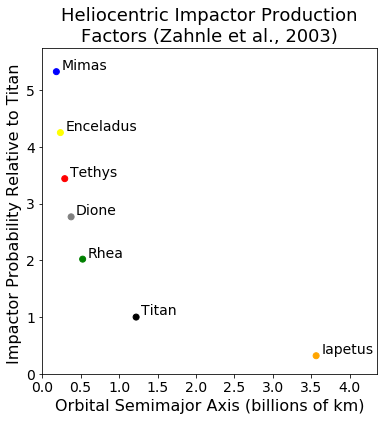

In [82]:
plt.figure(figsize=(6,6))
x = np.array([ro_mimas, ro_enceladus, ro_tethys, ro_dione, ro_rhea, ro_titan, ro_iapetus])/1e9
y = [pt_mimas, pt_enceladus, pt_tethys, pt_dione, pt_rhea, pt_titan, pt_iapetus]
names = ['Mimas','Enceladus', 'Tethys', 'Dione', 'Rhea', 'Titan', 'Iapetus']
colors = ['blue', 'yellow', 'red', 'gray', 'green', 'black', 'orange']
plt.scatter(x, y, c=colors)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i]),xytext=(5, 2), textcoords='offset points', size=14)
plt.xlim([0,4.35])
plt.ylim([0,5.75])
plt.xlabel('Orbital Semimajor Axis (billions of km)',size=16)
plt.ylabel('Impactor Probability Relative to Titan ',size=16)
plt.title('Heliocentric Impactor Production\nFactors (Zahnle et al., 2003)',size=18)
plt.xticks(size=14)
plt.yticks(size=14)
fig = plt.gcf()
fig.savefig('HeliocenticImpactorProbabilityFactors.pdf', bbox_inches='tight')

In [83]:
def ig_error(p,n):
    return gamma.ppf(1-p,n+1),gamma.ppf(0.5,n+1),gamma.ppf(p,n+1)

def ig_50(n):
    return gamma.ppf(0.5,n+1)

def ig_lower(n):
    return gamma.ppf(0.5,n+1)-gamma.ppf(1-0.841345,n+1)

def ig_upper(n):
    return gamma.ppf(0.841345,n+1)-gamma.ppf(0.5,n+1)

def ig_ndist(n,increment_exponent):
    return np.array([gamma.ppf(p,n+1) for p in list(np.arange(0.1**increment_exponent,1.0,0.1**increment_exponent))])


def poisson_error_bars(p,n):
    nrange = max(n*10.0,10.0)
    inc = nrange/100000.0
    X = np.arange(inc,nrange,inc)
    Y = [poisson.pmf(n,m) for m in X]
    Yc = np.cumsum(Y)/len(X)*nrange
    cdfn = pd.DataFrame({'n':X,'cp':Yc})
    return [cdfn[cdfn['cp']<cp].iloc[-1].tolist()[1] for cp in [1.0-p,0.5,p]]

def poisson_error_bars(p,n):
    nrange = max(n*10.0,10.0)
    inc = nrange/100000.0
    X = np.arange(0.5*inc,nrange,inc)
    Y = [poisson.pmf(n,m) for m in X]
    Yc = np.cumsum(Y)/len(X)*nrange
    cdfn = pd.DataFrame({'n':X,'cp':Yc})
    return [cdfn[cdfn['cp']<cp].iloc[-1].tolist()[1] for cp in [1.0-p,0.5,p]]

In [84]:
n1_ndist = ig_ndist(1,4)
n1_percentiles = [np.percentile(n1_ndist,i) for i in np.arange(0.0005,100.0,0.0005)]

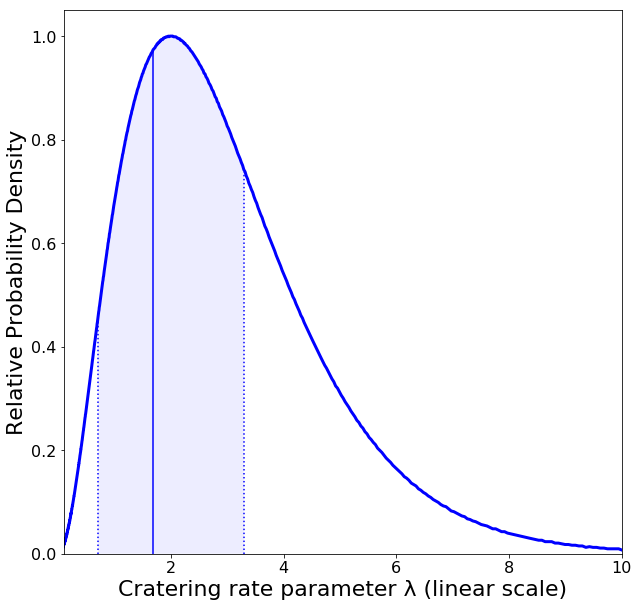

In [85]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
Y,bin_edges=np.histogram(np.log10(n1_percentiles),1000, density=True)
bin_edges = 10**np.array(bin_edges)
Y = np.array(Y)/max(Y)
X =[np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))]
plt.plot(X,Y,color_dict['Mimas'], linewidth=3)
low1,med1,high1 = tuple(np.percentile(n1_percentiles,[100-84.1345,50,84.1345]))
ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict['Mimas'], alpha=0.07)
ax.plot([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict['Mimas'])
ax.plot([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict['Mimas'])
ax.plot([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict['Mimas'])
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('Cratering rate parameter λ (linear scale)',size=22)
plt.ylabel('Relative Probability Density',size=22)
plt.xlim([0.1,10])
plt.ylim([0,1.05])
pfig = plt.gcf()
pfig.savefig('n1_PDF_linear.pdf',bbox_inches='tight')

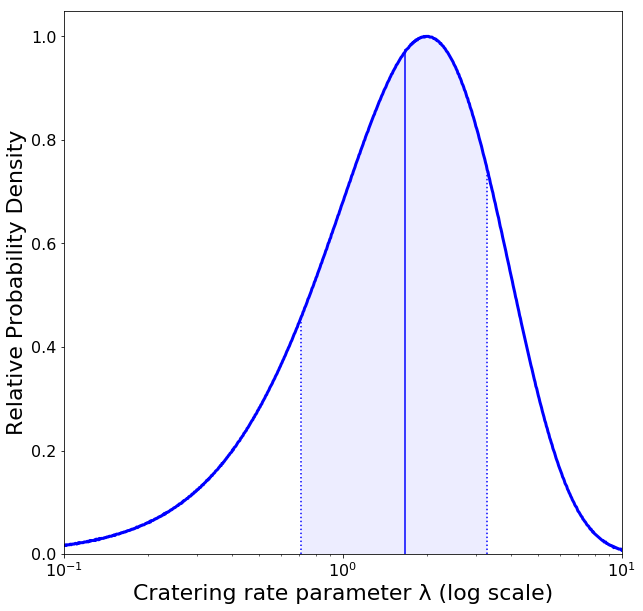

In [86]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
Y,bin_edges=np.histogram(np.log10(n1_percentiles),1000, density=True)
bin_edges = 10**np.array(bin_edges)
Y = np.array(Y)/max(Y)
X =[np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))]
plt.plot(X,Y,color_dict['Mimas'], linewidth=3)
low1,med1,high1 = tuple(np.percentile(n1_percentiles,[100-84.1345,50,84.1345]))
ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict['Mimas'], alpha=0.07)
ax.semilogx([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict['Mimas'])
ax.semilogx([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict['Mimas'])
ax.semilogx([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict['Mimas'])
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('Cratering rate parameter λ (log scale)',size=22)
plt.ylabel('Relative Probability Density',size=22)
plt.xlim([0.1,10])
plt.ylim([0,1.05])
pfig = plt.gcf()
pfig.savefig('n1_PDF_log.pdf',bbox_inches='tight')

In [280]:
100-3.4034

96.5966

In [111]:
100-2.29725

97.70275

In [294]:
2*r_mimas

396000.0

In [285]:
(32000**2/(G*m_mimas/r_mimas**2))

16044400291.319904

In [295]:
100*G*m_mimas/r_mimas**2

6.382289031731457

In [248]:
Ds = 11.9 * (14**2/(100*G*m_mimas/r_mimas**2))**0.217 * (1/1)**0.333 * (2*20)**0.783
D_Destruction = Ds * (Ds/15)**0.13
D_Destruction

699.2922159026303

In [28]:
10**(log(422.3486366636343/139.0)*-2.5)

0.062138284485389855

In [31]:
47.822375565159362 * 10**(log(422.3486366636343/139.0)*-2.5) 

2.971600377635029

In [ ]:
 11.9􏰌􏰓  􏰍0.217􏰌􏰒 /􏰒 􏰍0.333 d**0.783 km

In [200]:
Q_star = 1.2*(r_mimas*100)**1.26 * 1e-4
Q_star

187490.5511686088

In [209]:
2.1*(r_mimas*100)**1.19 * 1e-4

101216.39641211549

In [174]:
0.5*32000/((4/3)*math.pi*r_mimas**2)

0.0031178195157273653

In [211]:
vi_h(0.6, e_mimas, m_mimas, r_mimas, ro_mimas)

25169.952886941344

In [247]:
0.5*1000*((4/3)*math.pi*20000**3)*14000**2 / (1000*(4/3)*math.pi*r_mimas**3)

100999.79490857973

In [245]:
0.5*1000*((4/3)*math.pi*17000**3)*32000**2 

1.0536717453371155e+25

In [246]:
0.5*1000*((4/3)*math.pi*17000**3)*32000**2 / (1000*(4/3)*math.pi*r_mimas**3)

324056.8113540259

In [192]:
Q_star

187490.5511686088

In [88]:
mimas_area = r_mimas**2 * math.pi * 4 /1000000.0
herschel_ndist = ig_ndist(1,4)

In [228]:
random.choice(ir_h48_dict['Mimas'])

33.029472285126403

In [285]:
t1 = time.time()
full_ndist = [random.choice(herschel_ndist) * random.choice(ir_h48_dict['Mimas']) for i in range(100000)]
herschel_percentiles_raw = [np.percentile(full_ndist,i) for i in np.arange(0.0005,100.0,0.0005)]
herschel_percentiles_48 = 10**(log(D_Destruction/139.0)*-2.2) * np.array(herschel_percentiles_raw)
time.time()-t1

1197.3339598178864

In [278]:
t1 = time.time()
full_ndist = [random.choice(herschel_ndist) * random.choice(ir_h65_dict['Mimas']) for i in range(100000)]
herschel_percentiles_raw = [np.percentile(full_ndist,i) for i in np.arange(0.0005,100.0,0.0005)]
herschel_percentiles_65 = 10**(log(D_Destruction/139.0)*-2.2) * np.array(herschel_percentiles_raw)
time.time()-t1

117.90987586975098

In [264]:
def get_destruction_prob(herschel_percentiles):
    best_p = 0
    error = 100000000
    for i in np.arange(0,100,1):
        if abs(np.percentile(herschel_percentiles,i) - 1)<error:
            error = abs(np.percentile(herschel_percentiles,i) - 1)
            best_p = i
    for i in np.arange(best_p-1,best_p+1,0.01):
        if abs(np.percentile(herschel_percentiles,i) - 1)<error:
            error = abs(np.percentile(herschel_percentiles,i) - 1)
            best_p = i
    for i in np.arange(best_p-0.01,best_p+0.01,0.0001):
        if abs(np.percentile(herschel_percentiles,i) - 1)<error:
            error = abs(np.percentile(herschel_percentiles,i) - 1)
            best_p = i
    for i in np.arange(best_p-0.0001,best_p+0.0001,0.000001):
        if abs(np.percentile(herschel_percentiles,i) - 1)<error:
            error = abs(np.percentile(herschel_percentiles,i) - 1)
            best_p = i
    return 100-best_p

In [279]:
get_destruction_prob(herschel_percentiles_48),get_destruction_prob(herschel_percentiles_65)

(88.429259000000144, 96.275104999999968)

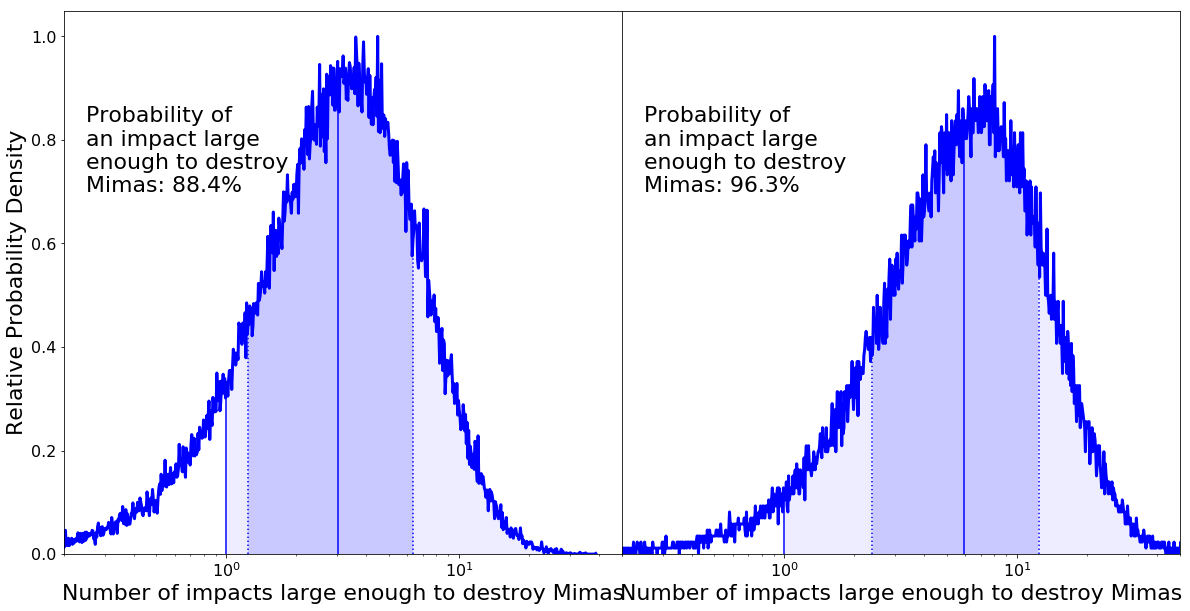

In [294]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121)
Y,bin_edges=np.histogram(np.log10(herschel_percentiles_48),1000, density=True)
bin_edges = 10**np.array(bin_edges)
Y = np.array(Y)/max(Y)
X = np.array([np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))])
plt.plot(X,Y,color_dict['Mimas'], linewidth=3)
low1,med1,high1 = tuple(np.percentile(herschel_percentiles_48,[100-84.1345,50,84.1345]))
ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict['Mimas'], alpha=0.15)
ax.semilogx([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict['Mimas'])
ax.semilogx([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict['Mimas'])
ax.semilogx([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict['Mimas'])
ax.semilogx([1,1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > 1)]],color=color_dict['Mimas'])
ax.fill_between(X,0,Y, where=(1.0<X), facecolor=color_dict['Mimas'], alpha=0.07)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('Number of impacts large enough to destroy Mimas',size=22)
plt.ylabel('Relative Probability Density',size=22)
plt.xlim([0.2,50])
plt.ylim([0,1.05])
plt.text(0.25,0.7,'Probability of\nan impact large\nenough to destroy\nMimas: 88.4%',fontsize=22)
ax = fig.add_subplot(122)
Y,bin_edges=np.histogram(np.log10(herschel_percentiles_65),1000, density=True)
bin_edges = 10**np.array(bin_edges)
Y = np.array(Y)/max(Y)
X = np.array([np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))])
plt.plot(X,Y,color_dict['Mimas'], linewidth=3)
low1,med1,high1 = tuple(np.percentile(herschel_percentiles_65,[100-84.1345,50,84.1345]))
ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict['Mimas'], alpha=0.15)
ax.semilogx([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict['Mimas'])
ax.semilogx([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict['Mimas'])
ax.semilogx([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict['Mimas'])
ax.semilogx([1,1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > 1)]],color=color_dict['Mimas'])
ax.fill_between(X,0,Y, where=(1.0<X), facecolor=color_dict['Mimas'], alpha=0.07)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('Number of impacts large enough to destroy Mimas',size=22)
plt.ylabel('Relative Probability Density',size=22)
plt.xlim([0.2,50])
plt.ylim([0,1.05])
plt.text(0.25,0.7,'Probability of\nan impact large\nenough to destroy\nMimas: 96.3%',fontsize=22)
ax.get_yaxis().set_visible(False)
ax.get_yaxis().set_ticklabels([])
fig.subplots_adjust(wspace=0,hspace=0)
pfig = plt.gcf()
pfig.savefig('herschel_probabilities.pdf',bbox_inches='tight')

In [91]:
def d_scale_factor(e_projectile, e_moon, m_moon, r_moon, ro_moon, alpha):
    vi_moon = vi(e_projectile, e_moon, m_moon, r_moon, ro_moon)
    vi_titan = vi(e_projectile, e_titan, m_titan, r_titan, ro_titan)
    g_titan = G*m_titan/r_titan**2
    g_moon = G*m_moon/r_moon**2
    return (g_titan/g_moon)**(-1.0*alpha/3.0) * (vi_titan/vi_moon)**(2.0*alpha/3.0)

def d_scale_factor_enceladus(e_projectile, e_moon, m_moon, r_moon, ro_moon, alpha):
    vi_moon = vi(e_projectile, e_moon, m_moon, r_moon, ro_moon)
    vi_enceladus = vi(e_projectile, e_enceladus, m_enceladus, r_enceladus, ro_enceladus)
    g_enceladus = G*m_enceladus/r_enceladus**2
    g_moon = G*m_moon/r_moon**2
    return (g_enceladus/g_moon)**(-1.0*alpha/3.0) * (vi_enceladus/vi_moon)**(2.0*alpha/3.0)

def d_scale_factor_h(e_projectile, e_moon, m_moon, r_moon, ro_moon, alpha):
    vi_moon = vi_h(e_projectile, e_moon, m_moon, r_moon, ro_moon)
    vi_titan = vi_h(e_projectile, e_titan, m_titan, r_titan, ro_titan)
    g_titan = G*m_titan/r_titan**2
    g_moon = G*m_moon/r_moon**2
    return (g_titan/g_moon)**(-1.0*alpha/3.0) * (vi_titan/vi_moon)**(2.0*alpha/3.0)

In [92]:
def V_moon(key,X,alpha):
    return [vi(ep, e_dict[key], m_dict[key], r_dict[key], ro_dict[key]) for ep in X]
def V_h_moon(key,X,alpha):
    return [vi_h(ep, e_dict[key], m_dict[key], r_dict[key], ro_dict[key]) for ep in X]
def Y_moon(key,X,alpha):
    return [d_scale_factor(ep, e_dict[key], m_dict[key], r_dict[key], ro_dict[key], alpha) for ep in X]
def Y_h_moon(key,X,alpha):
    return [d_scale_factor_h(ep, e_dict[key], m_dict[key], r_dict[key], ro_dict[key], alpha) for ep in X]

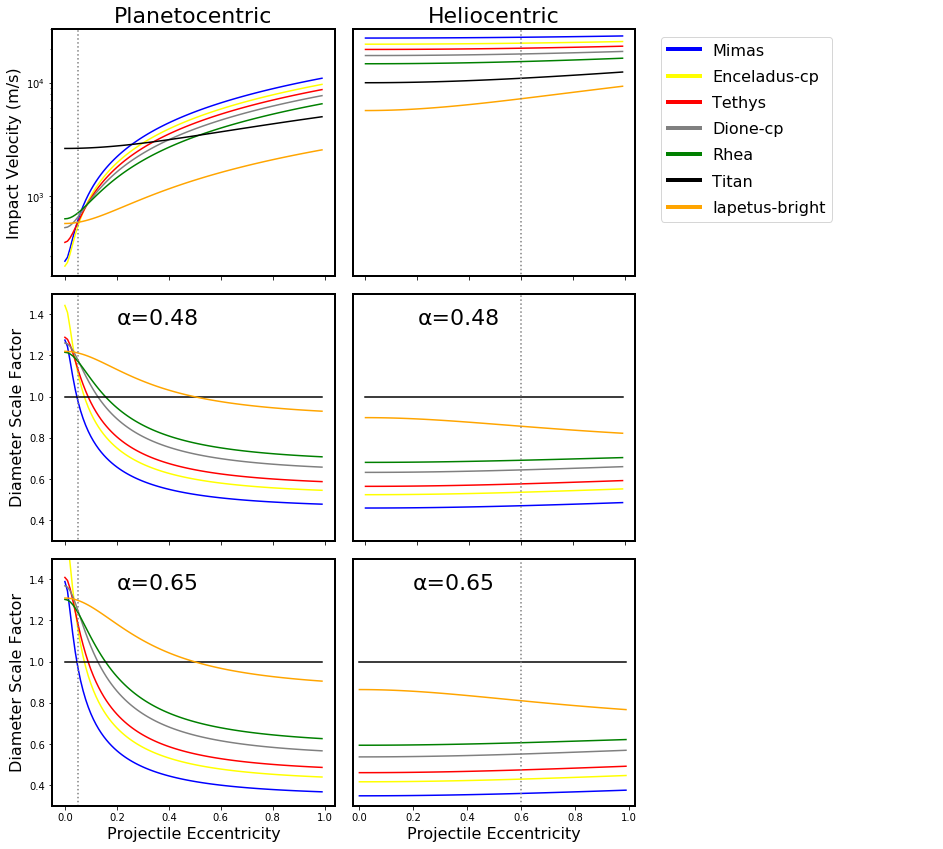

In [93]:
X = np.arange(0.0,1.0,0.01)

fig = plt.figure(figsize=(17.6/2*1.5,(14*1.5+2.8)/2))

ax = fig.add_subplot(331)
for key in cp_keys[:5] + ['Titan'] + [cp_keys[5]]:
    plt.semilogy(X,V_moon(key,X,0.65), color=color_dict[key], label=key.partition('-')[0])
plt.semilogy([0.05,0.05],[100,100000],':',color='gray')
plt.ylim([200,30000])
ax.get_xaxis().set_ticklabels([])
plt.ylabel('Impact Velocity (m/s)',size=16)
plt.title('Planetocentric',size=22)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax = fig.add_subplot(332)
for key in cp_keys[:5] + ['Titan'] + [cp_keys[5]]:
    plt.semilogy(X,V_h_moon(key,X,0.65), color=color_dict[key], label=key.partition('-')[0])
plt.semilogy([0.6,0.6],[100,100000],':',color='gray')
plt.ylim([200,30000])
ax.get_xaxis().set_ticklabels([])
plt.title('Heliocentric',size=22)
ax.get_yaxis().set_visible(False)
ax.get_yaxis().set_ticklabels([])
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax = fig.add_subplot(334)
for key in cp_keys[:5] + ['Titan'] + [cp_keys[5]]:
    plt.plot(X,Y_moon(key,X,0.48), color=color_dict[key], label=key.partition('-')[0])
plt.plot([0.05,0.05],[0,2],':',color='gray')
plt.ylim([0.3,1.5])
plt.text(0.2,1.35,'α=0.48',fontsize=22)
ax.get_xaxis().set_ticklabels([])
plt.ylabel('Diameter Scale Factor',size=16)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax = fig.add_subplot(335)
for key in cp_keys[:5] + ['Titan'] + [cp_keys[5]]:
    plt.plot(X,Y_h_moon(key,X,0.48), color=color_dict[key], label=key.partition('-')[0])
plt.plot([0.6,0.6],[0,2],':',color='gray')
plt.ylim([0.3,1.5])
plt.text(0.2,1.35,'α=0.48',fontsize=22)
ax.get_yaxis().set_visible(False)
ax.get_yaxis().set_ticklabels([])
ax.get_xaxis().set_ticklabels([])
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax = fig.add_subplot(337)
for key in cp_keys[:5] + ['Titan'] + [cp_keys[5]]:
    plt.plot(X,Y_moon(key,X,0.65), color=color_dict[key], label=key.partition('-')[0])
plt.plot([0.05,0.05],[0,2],':',color='gray')
plt.ylim([0.3,1.5])
plt.text(0.2,1.35,'α=0.65',fontsize=22)
plt.xlabel('Projectile Eccentricity',size=16)
plt.ylabel('Diameter Scale Factor',size=16)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax = fig.add_subplot(338)
for key in cp_keys[:5] + ['Titan'] + [cp_keys[5]]:
    plt.plot(X,Y_h_moon(key,X,0.65), color=color_dict[key], label=key.partition('-')[0])
plt.plot([0.6,0.6],[0,2],':',color='gray')
plt.xlim([-0.025,1.025])
plt.ylim([0.3,1.5])
plt.text(0.2,1.35,'α=0.65',fontsize=22)
plt.xlabel('Projectile Eccentricity',size=16)
ax.get_yaxis().set_visible(False)
ax.get_yaxis().set_ticklabels([])
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax = fig.add_subplot(333)
custom_lines = [Line2D([0], [0], color=color_dict[key], lw=4) for key in cp_keys]
custom_lines.insert(5,Line2D([0], [0], color='Black', lw=4))
ax.legend(custom_lines, cp_keys[:5] + ['Titan'] + [cp_keys[5]],labelspacing=0.7, fontsize=16, loc=2)
ax.get_yaxis().set_visible(False)
ax.get_yaxis().set_ticklabels([])
ax.get_xaxis().set_visible(False)
ax.get_xaxis().set_ticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(wspace=0.02)
fig.subplots_adjust(hspace=0.02)

plt.tight_layout()

fig.savefig('ScaleFactorPanelFigure.pdf')

In [94]:
bins = [2.0*(math.sqrt(2.0)**n) for n in list(range(5,17))]
titan_ds = pd.read_csv('titan_data.csv').astype('float')
titan_gmeans_d = np.zeros(len(bins)-1)
n_d = np.zeros(len(bins)-1)
for i in list(range(len(bins)-1)):
    bin_craters = titan_ds[(titan_ds['D'] >= bins[i]) & (titan_ds['D'] < bins[i+1])]
    n = bin_craters.shape[0]
    n_d[i] = n
    if n!=0:
        titan_gmeans_d[i] = gmean(bin_craters['D'].tolist())
full_bins = [2.0*(math.sqrt(2.0)**n) for n in list(range(1,17))]
full_bin_gmeans = [gmean([full_bins[i],full_bins[i+1]]) for i in list(range(len(full_bins)-1))]
prob8 = 58.3 + (gmean([bins[8],bins[9]]) - gmean([bins[7],bins[8]]))*(76.0-58.3)/(gmean([bins[10],bins[11]]) - gmean([bins[7],bins[8]]))
prob9 = 58.3 + (gmean([bins[10],bins[9]]) - gmean([bins[7],bins[8]]))*(76.0-58.3)/(gmean([bins[10],bins[11]]) - gmean([bins[7],bins[8]]))
titan_counts = pd.DataFrame({'count':[2,11,5,8,2,4,2,2,0,0,1],'prob':[33.0,33.0,33.0,41.4,46.4,50.0,53.7,58.3,\
            prob8,prob9,76.0]}, index=titan_gmeans_d)
titan_counts = titan_counts[titan_counts['count']!=0]
titan_counts.sort_index(ascending=False, inplace=True)
area_titan = 4*math.pi*r_titan**2/10.0**6
titan_density = ((titan_counts['count']/titan_counts['prob']*100.0).cumsum()/100*titan_counts['prob'])\
            .apply(ig_50)/100*titan_counts['prob']/area_titan
titan_lower = ((titan_counts['count']/titan_counts['prob']*100.0).cumsum()/100*titan_counts['prob'])\
            .apply(ig_lower)/100*titan_counts['prob']/area_titan
titan_upper = ((titan_counts['count']/titan_counts['prob']*100.0).cumsum()/100*titan_counts['prob'])\
            .apply(ig_upper)/100*titan_counts['prob']/area_titan
titan_ndist = ((titan_counts['count']/titan_counts['prob']*100.0).cumsum()/100*titan_counts['prob'])\
            .apply(lambda var: ig_ndist(var,3.5))/100*titan_counts['prob']/area_titan
titan_data = pd.DataFrame({'density':titan_density.values, 'lower':titan_lower.values, \
            'upper':titan_upper.values, 'ndist':titan_ndist.values, 'D':list(titan_density.index.values)})

In [95]:
def get_binned_dict(alpha, model='planetocentric'):
    return_dict = {}
    for key in cp_keys:
        area = cp_dict[key]['Area (km^2)'][0]
        full_area = r_dict[key]**2 * math.pi * 4 /1000000.0
        if model=='planetocentric':
            sf = d_scale_factor(0.05, e_dict[key], m_dict[key], r_dict[key], ro_dict[key], alpha)
        if model in ['heliocentric', 'heliocentric-unadjusted']:
            sf = d_scale_factor_h(0.05, e_dict[key], m_dict[key], r_dict[key], ro_dict[key], alpha)
        else:
            NameError('Bad model name')
        if model=='heliocentric': 
            pt = pt_dict[key]
        else:
            pt = 1.0
        cp_dict[key] = cp_dict[key].assign(D_sf=cp_dict[key]['D (km)']*sf).sort_values(by='D_sf', ascending=False)
        min_d = cp_dict[key]['D_sf'].min()
        n_d = list(np.zeros(len(full_bin_gmeans)))
        gmeans_d = list(np.zeros(len(full_bin_gmeans)))
        binned_d = list(np.zeros(len(full_bin_gmeans)))
        binned_l = list(np.zeros(len(full_bin_gmeans)))
        binned_u = list(np.zeros(len(full_bin_gmeans)))
        binned_ndist = list(np.zeros(len(full_bin_gmeans)))
        for i in list(range(len(full_bins)-1)):
            if full_bins[i] >= min_d:
                bin_craters = cp_dict[key][(cp_dict[key]['D_sf'] >= full_bins[i]) & (cp_dict[key]['D_sf'] < full_bins[i+1])]
                n = bin_craters.shape[0]
                n_d[i] = n
                if n!=0:
                    gmeans_d[i] = gmean(bin_craters['D_sf'].tolist())
            else:
                n_d[i] = 1000000000000
        n_d.reverse()
        n_d = list(np.cumsum(n_d))
        n_d.reverse()
        i_e = 3.5
        for i in list(range(len(n_d))):
            if n_d[i] > 500000000000.0 or n_d[i]==0:
                binned_d[i] = None
            else:
                if key in ['Mimas','Tethys','Dione-cp','Rhea']:
                    af = area/full_area
                elif key == 'Iapetus-bright':
                    af = 4*area/full_area
                elif key == 'Enceladus-cp':
                    af = 0
                else:
                    NameError('Wrong key name')
                binned_d[i] = ig_50(n_d[i] + af)/area/pt
                binned_l[i] = ig_lower(n_d[i] + af)/area/pt
                binned_u[i] = ig_upper(n_d[i] + af)/area/pt
                binned_ndist[i] = ig_ndist(n_d[i] + af, i_e)/area/pt
        big_D_dict = {'Mimas':[139.0], 'Tethys':[445.0], 'Dione-cp':[350],'Rhea':[480],'Iapetus-bright':[580.0,504.0,445.0,424.0]}
        if key in big_D_dict.keys():
            for i in list(range(len(big_D_dict[key]))):
                gmeans_d.append(big_D_dict[key][i] * sf)
                binned_d.append(ig_50(float(i+1))/full_area/pt)
                binned_l.append(ig_lower(float(i+1))/full_area/pt)
                binned_u.append(ig_upper(float(i+1))/full_area/pt)
                binned_ndist.append(ig_ndist(1.0,i_e)/full_area/pt)
        bin_df = pd.DataFrame({'D_sf':gmeans_d, 'density_sf':binned_d, 'lower_sf':binned_l, 'upper_sf':binned_u, 'ndist_sf':binned_ndist})
        return_dict[key] = bin_df[~(bin_df['density_sf'].isnull()|bin_df['D_sf'].isnull()|(bin_df['D_sf'] == 0.0))]
    return return_dict

In [96]:
binned_dict_p48 = get_binned_dict(0.48,model='planetocentric')
binned_dict_h48 = get_binned_dict(0.48,model='heliocentric')
binned_dict_p65 = get_binned_dict(0.65,model='planetocentric')
binned_dict_h65 = get_binned_dict(0.65,model='heliocentric')

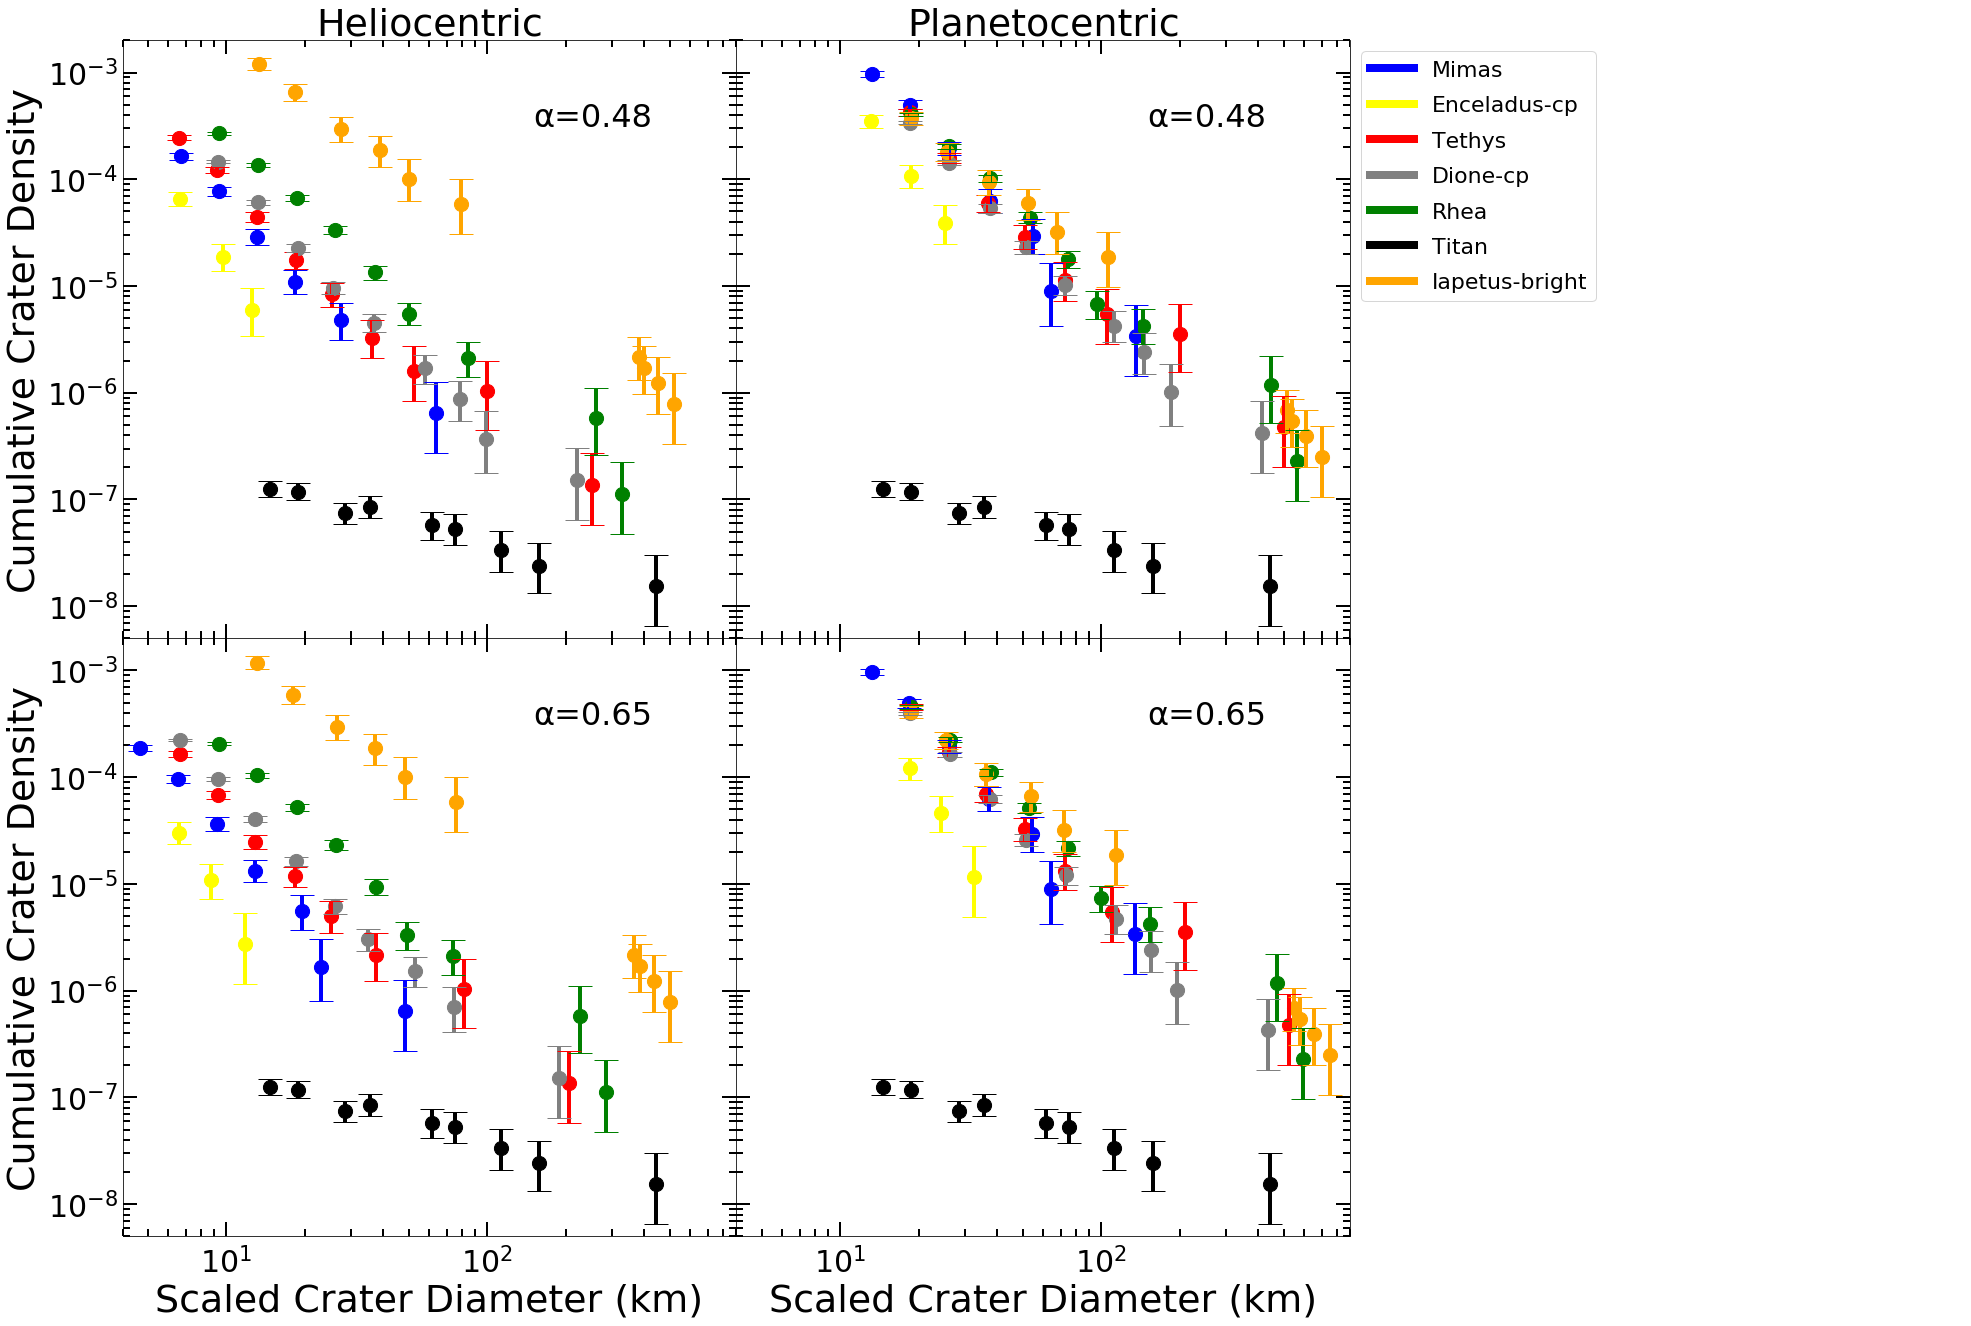

In [468]:
plt.rcParams['errorbar.capsize'] = 12
title_list = ['Heliocentric','Planetocentric','','','','']
binned_dict_list = [binned_dict_h48,binned_dict_p48,'',binned_dict_h65,binned_dict_p65,'']
fig = plt.figure(figsize=(33,22))
for i in list(range(6)):
    if i%3!=2:
        ax = fig.add_subplot(231 + i)
        binned_dict = binned_dict_list[i]
        plt.rcParams['errorbar.capsize'] = 12
        plt.rcParams['lines.linewidth'] = 4
        ax = binned_dict['Tethys'].plot(y='density_sf',x='D_sf',logx=True, logy=True, kind='scatter', legend=True, ax=ax)
        for key in cp_keys:
            binned_dict[key].plot(y='density_sf',x='D_sf', \
                              yerr=np.array([binned_dict[key][['lower_sf','upper_sf']].values.transpose()]), 
                              logx=True, logy=True, kind='scatter', 
                              ax=ax, color=color_dict[key], legend=True, s=200)
        titan_data.plot(y='density', x='D', yerr=np.array([titan_data[['lower','upper']].values.transpose()]), \
                        color='black', logx=True, logy=True, kind='scatter', ax=ax, s=200)
        plt.xticks(size=30)
        if i%3==0:
            plt.yticks(size=30)
            plt.ylabel('Cumulative Crater Density',size=38)
        else:
            ax.get_yaxis().set_ticklabels([])
            plt.ylabel('',size=1)
        plt.xlabel('Scaled Crater Diameter (km)',size=38)
        plt.title(title_list[i],size=38)
        plt.xlim([4,900])
        plt.ylim([5*10.0**-9,2*10.0**-3])
        if i < 3:
            plt.text(150,10**-3.5,'α=0.48',fontsize=32)
        else:
            plt.text(150,10**-3.5,'α=0.65',fontsize=32)
    elif i==2:
        ax = fig.add_subplot(231 + i)
        custom_lines = [Line2D([0], [0], color=color_dict[key], lw=8) for key in cp_keys]
        custom_lines.insert(5,Line2D([0], [0], color='Black', lw=8))
        ax.legend(custom_lines, cp_keys[:5] + ['Titan'] + [cp_keys[5]],labelspacing=0.7, fontsize=22, loc=2)
        ax.get_yaxis().set_visible(False)
        ax.get_yaxis().set_ticklabels([])
        ax.get_xaxis().set_visible(False)
        ax.get_xaxis().set_ticklabels([])
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(length=14, width=2)
    ax.get_xaxis().set_tick_params(length=7, width=2, which='minor')
    ax.get_yaxis().set_tick_params(length=14, width=2)
    ax.get_yaxis().set_tick_params(length=7, width=2, which='minor')
    ax.get_xaxis().set_ticks_position('both')
    ax.get_yaxis().set_ticks_position('both')
    ax.get_xaxis().set_tick_params(pad=10, which='both')
    ax.get_yaxis().set_tick_params(pad=5, which='both')
    
fig.subplots_adjust(wspace=0,hspace=0)

pfig = plt.gcf()
pfig.savefig('CraterCountsPanel.pdf',bbox_inches='tight')
plt.rcParams['lines.linewidth'] = 1

In [97]:
def get_titan_lines(n):
    data = pd.DataFrame(titan_data['D'])
    x = list(titan_data['D'].apply(log))
    lrs = []
    for i in list(range(n)):
        data = data.assign(y = titan_data['ndist'].apply(random.choice))
        y = list(data['y'].apply(log))
        m,b,r,p,stderr = linregress(x,y)
        lrs.append((m,b))
    return pd.DataFrame(lrs,columns=['m','b'])

<Figure size 432x288 with 0 Axes>

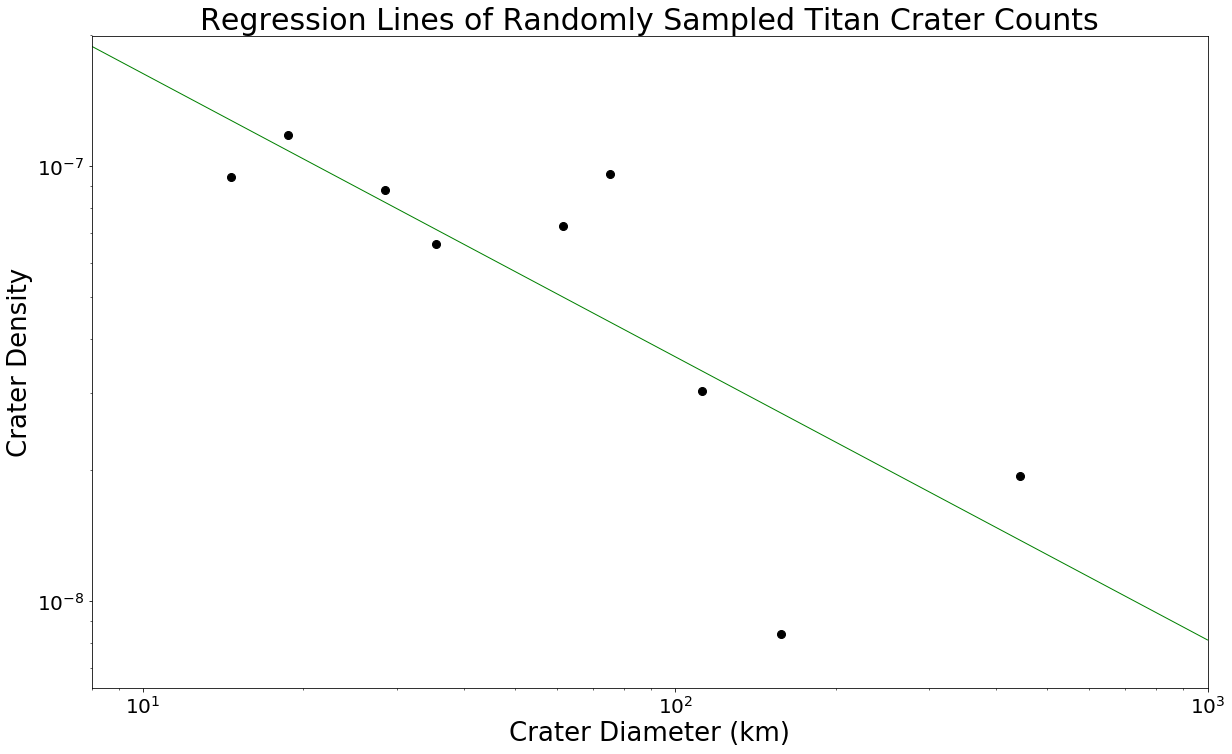

In [51]:
fig = plt.figure()
titan_data.plot(y='density', x='D', yerr=(titan_data[['lower','upper']].values.transpose()), color='white', \
                logx=True, logy=True, kind='scatter',figsize=(20,12), ylim=[10**-8.2,10**-6.7], xlim=[8,1000])
data = pd.DataFrame(titan_data['D'])
x = list(titan_data['D'].apply(log))
for i in range(1):
    data = data.assign(y = titan_data['ndist'].apply(random.choice))
    y = list(data['y'].apply(log))
    m,b,r,p,stderr = linregress(x,y)
    xmin=8
    xmax=1000
    plt.plot([xmin,xmax],[10**(b + m*log(xmin)), 10**(b + m*log(xmax))],'g')
    plt.plot(10**np.array(x),10**np.array(y),'ko',markersize=8)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('Crater Diameter (km)',size=26)
plt.ylabel('Crater Density',size=26)
plt.title('Regression Lines of Randomly Sampled Titan Crater Counts',size=30)
fig=plt.gcf()
fig.savefig('RandomSample1.pdf', bbox_inches='tight')

In [98]:
def find_line_i(input_tuple):
    x,y_ndist = input_tuple
    y = list(y_ndist.apply(random.choice).apply(log))
    m,b,r,p,stderr = linregress(x,y)
    return (m,b)

In [99]:
def get_lines(binned_dict,key,n):
    x = list(binned_dict[key]['D_sf'].apply(log))
    y_ndist = binned_dict[key]['ndist_sf']
    input_list = [(x,y_ndist) for i in range(n)]
    with Pool(5) as pool:
        lrs = pool.map(find_line_i, input_list)
        pool.close()
    return pd.DataFrame(lrs,columns=['m','b'])

In [100]:
def get_percentile(lines,x,p):
    vlist = [line.m*x + line.b for line in lines.itertuples()]
    return np.percentile(vlist,p)

In [101]:
titan_lines = get_titan_lines(1000)

In [102]:
def plot_moon_lines(binned_dict,key,n,ax = 'None',do_legend = True):
    moon_lines = get_lines(binned_dict,key,n)
    xe = np.arange(0.5,3,0.01)
    mtitan = [10**get_percentile(titan_lines,xei,50.0) for xei in xe]
    utitan = [10**get_percentile(titan_lines,xei,84.1345) for xei in xe]
    ltitan = [10**get_percentile(titan_lines,xei,100.0-84.1345) for xei in xe]
    mmoon = [10**get_percentile(moon_lines,xei,50.0) for xei in xe]
    umoon = [10**get_percentile(moon_lines,xei,84.1345) for xei in xe]
    lmoon = [10**get_percentile(moon_lines,xei,100.0-84.1345) for xei in xe]
    if ax == 'None':
        ax = binned_dict[key].plot(y='density_sf',x='D_sf',logx=True, logy=True, kind='scatter')
    else:
        binned_dict[key].plot(y='density_sf',x='D_sf',logx=True, logy=True, kind='scatter', ax=ax)
    binned_dict[key].plot(y='density_sf',x='D_sf', yerr=(binned_dict[key][['lower_sf','upper_sf']].values.transpose()), 
                          logx=True, logy=True, kind='scatter', 
                          ax=ax, color=color_dict[key], s=30)
    titan_data.plot(y='density', x='D', yerr=(titan_data[['lower','upper']].values.transpose()), color='black', \
                    logx=True, logy=True, kind='scatter', ax=ax, s=30)
    pd.DataFrame({'Titan upper bound':utitan,'Titan median':mtitan,'Titan lower bound':ltitan},index=[10**i for i in xe]).plot(\
                    logx=True, logy=True, ax=ax, color='black',\
                    style=[':','-',':'], legend=do_legend)
    pd.DataFrame({key.partition('-')[0] + ' upper bound':umoon, key.partition('-')[0] + ' median':mmoon, key.partition('-')[0] + ' lower bound':lmoon},index=[10**i for i in xe]).plot(\
                        logx=True, logy=True, ax=ax, color=color_dict[key],\
                        style=[':','-',':'], legend=do_legend)
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.ylim([10**-8.75,10**-2.5])
    plt.xlabel('Crater Diameter (km)',size=22)
    plt.ylabel('Crater Density',size=22)

In [103]:
def get_mean_m(binned_dict,n):
    slopes=[]
    for key in cp_keys:
        slopes.append(get_lines(binned_dict,key,n)['m'].median())
    m_df = pd.DataFrame({'slope':slopes}, index = cp_keys)
    return float(m_df.drop('Enceladus-cp').mean()),float(m_df.drop('Enceladus-cp').std())

In [104]:
def get_mean_m_dist(binned_dict,n):
    t1=time.time()
    slopes=[]
    for key in set(cp_keys)-{'Enceladus-cp'}:
        slopes.append(get_lines(binned_dict,key,n)['m'])
    t2=time.time()
    #print('Run time: ' + str(round(t2-t1,2)) + ' s')
    mean_m_dist = [np.mean([random.choice(slope) for slope in slopes]) for i in range(n)]
    return mean_m_dist

In [105]:
def get_m_and_b(binned_dict,key,n,mean_m_dist):
    data = pd.DataFrame(binned_dict[key]['D_sf'])
    x_data = list(binned_dict[key]['D_sf'].apply(log))
    bs = []
    for i in list(range(n)):
        data = data.assign(y = binned_dict[key]['ndist_sf'].apply(random.choice))
        y_data = list(data['y'].apply(log))
        m = np.random.choice(mean_m_dist)
        def test_func(x, b):
            return m*x + b
        params, params_covariance = optimize.curve_fit(test_func, x_data, y_data)
        bs.append((m,params[0]))
    return bs

In [106]:
def calc_moon_b(input_tuple):
    binned_dict,key,m,x_data = input_tuple
    y_data = list(binned_dict[key]['ndist_sf'].apply(random.choice).apply(log))
    def test_func(x, b):
        return m*x + b
    params, params_covariance = optimize.curve_fit(test_func, x_data, y_data)
    moon_b = params[0]
    return moon_b

In [62]:
key = 'Rhea'
mean_m_dist = get_mean_m_dist(binned_dict_h65,1000)
binned_dict = binned_dict_h65
#data = pd.DataFrame(binned_dict[key]['D_sf'])
#data_iapetus = pd.DataFrame(binned_dict['Iapetus-bright']['D_sf'])
x_data = list(binned_dict[key]['D_sf'].apply(log))
x_data_iapetus = list(binned_dict['Iapetus-bright']['D_sf'].apply(log))
params = (binned_dict,key,mean_m_dist,x_data,x_data_iapetus)

In [107]:
def get_moon_b(binned_dict,key,m_list):
    x_data = list(binned_dict[key]['D_sf'].apply(log))
    input_list = [(binned_dict,key,m,x_data) for m in m_list]
    with Pool(5) as pool:
        moon_bs = pool.map(calc_moon_b, input_list)
        pool.close()
    return np.array(moon_bs)

In [108]:
def get_bs_dict(binned_dict,n1,n2):
    mean_m_dist = get_mean_m_dist(binned_dict,n1)
    bs_dict = {}
    for key in cp_keys:
        bs_dict[key] = np.array(get_m_and_b(binned_dict,key,n2,mean_m_dist))
    return bs_dict,mean_m_dist

In [109]:
binned_dict = binned_dict_h48
n1=1000
t1=time.time()
mean_m_dist = get_mean_m_dist(binned_dict,n1)
t2=time.time()
print(t2-t1)

1.5229299068450928


In [65]:
binned_dict = binned_dict_h48
n1=1000
t1=time.time()
mean_m_dist = get_mean_m_dist(binned_dict,n1)
t2=time.time()
print(t2-t1)
n2=100000
t1=time.time()
input_list = [mean_m_dist for i in range(n2)]
with Pool(5) as pool:
    m_list = pool.map(np.random.choice,input_list)
    pool.close()
t2=time.time()
print(t2-t1)


1.3969271183013916
1.588371992111206


In [110]:
t1=time.time()
x_data = list(binned_dict[key]['D_sf'].apply(log))
input_list = [(binned_dict,key,m,x_data) for m in m_list]
with Pool(5) as pool:
    moon_bs = pool.map(calc_moon_b, input_list)
    pool.close()
t2=time.time()
print(t2-t1)

NameError: name 'm_list' is not defined

In [111]:
def get_iapetus_ratio_dict(binned_dict,n1,n2):
    mt1=time.time()
    print('Generating inputs...')
    t1=time.time()
    mean_m_dist = get_mean_m_dist(binned_dict,n1)
    input_list = [mean_m_dist for i in range(n2)]
    with Pool(5) as pool:
        m_list = pool.map(np.random.choice,input_list)
        pool.close()
    t2=time.time()
    print('Inputs generated in: ' + str(round(t2-t1,3)) + ' s\nCalculating ratios...')
    bs_dict = {}
    for key in cp_keys:
        t1=time.time()
        bs_dict[key] = np.array(get_moon_b(binned_dict,key,m_list))
        t2=time.time()
        print(key.partition('-')[0] + ' b values calculated in: ' + str(round(t2-t1,3)) + ' s')
    ratio_dict = {}
    print('Dividing...')
    t1=time.time()
    for key in set(cp_keys) - {'Iapetus-bright'}:
        ratio_dict[key] = 10**(bs_dict['Iapetus-bright']-bs_dict[key])
    t2=time.time()
    print('Divisions finished in: ' + str(round(t2-t1,3)) + ' s')
    mt2=time.time()
    print('Full run time: ' + str(round(mt2-mt1,3)) + ' s')
    return ratio_dict

In [77]:
n1=1000
n2=100000
ir_h48_dict = get_iapetus_ratio_dict(binned_dict_h48,n1,n2)

Generating inputs...
Inputs generated in: 3.316 s
Calculating ratios...
Mimas b values calculated in: 19.047 s
Enceladus b values calculated in: 19.509 s
Tethys b values calculated in: 19.893 s
Dione b values calculated in: 19.499 s
Rhea b values calculated in: 19.804 s
Iapetus b values calculated in: 19.705 s
Dividing...
Divisions finished in: 0.014 s
Full run time: 120.795 s


In [78]:
n1=10000
n2=1000000
ir_h48_dict = get_iapetus_ratio_dict(binned_dict_h48,n1,n2)
ir_h65_dict = get_iapetus_ratio_dict(binned_dict_h65,n1,n2)
ir_p48_dict = get_iapetus_ratio_dict(binned_dict_p48,n1,n2)
ir_p65_dict = get_iapetus_ratio_dict(binned_dict_p65,n1,n2)

Generating inputs...
Inputs generated in: 155.986 s
Calculating ratios...
Mimas b values calculated in: 191.646 s
Enceladus b values calculated in: 189.622 s
Tethys b values calculated in: 193.405 s
Dione b values calculated in: 191.907 s
Rhea b values calculated in: 199.914 s
Iapetus b values calculated in: 203.784 s
Dividing...
Divisions finished in: 0.127 s
Full run time: 1326.402 s
Generating inputs...
Inputs generated in: 159.157 s
Calculating ratios...
Mimas b values calculated in: 198.756 s
Enceladus b values calculated in: 195.958 s
Tethys b values calculated in: 196.643 s
Dione b values calculated in: 196.666 s
Rhea b values calculated in: 197.161 s
Iapetus b values calculated in: 196.312 s
Dividing...
Divisions finished in: 0.124 s
Full run time: 1340.787 s
Generating inputs...
Inputs generated in: 158.118 s
Calculating ratios...
Mimas b values calculated in: 195.123 s
Enceladus b values calculated in: 200.656 s
Tethys b values calculated in: 199.555 s
Dione b values calculat

In [112]:
t1=time.time()
bs_h48_dict,mean_h48_m_dist = get_bs_dict(binned_dict_h48,1000,1000)
bs_h65_dict,mean_h65_m_dist = get_bs_dict(binned_dict_h65,1000,1000)
bs_p48_dict,mean_p48_m_dist = get_bs_dict(binned_dict_p48,1000,1000)
bs_p65_dict,mean_p65_m_dist = get_bs_dict(binned_dict_p65,1000,1000)
t2=time.time()
print('Total run time: ' + str(round(t2-t1,2)) + ' s')

Total run time: 27.52 s


In [113]:
mean_h48_m,mean_h48_m_std = get_mean_m(binned_dict_h48,1000)
mean_h65_m,mean_h65_m_std = get_mean_m(binned_dict_h65,1000)
mean_p48_m,mean_p48_m_std = get_mean_m(binned_dict_p48,1000)
mean_p65_m,mean_p65_m_std = get_mean_m(binned_dict_p65,1000)

In [90]:
mean_h48_m,mean_h65_m,mean_p48_m,mean_p65_m

(-2.2055265521100322,
 -2.2121063121497917,
 -2.21891624922647,
 -2.2143562063869204)

In [79]:
if False:
    pkl.dump( ir_h48_dict, open('ir_h48_dict.pkl', 'wb'))
    pkl.dump( ir_h65_dict, open('ir_h65_dict.pkl', 'wb'))
    pkl.dump( ir_p48_dict, open('ir_p48_dict.pkl', 'wb'))
    pkl.dump( ir_p65_dict, open('ir_p65_dict.pkl', 'wb'))

In [114]:
ir_h48_dict = pkl.load(open('ir_h48_dict.pkl', 'rb'))
ir_h65_dict = pkl.load(open('ir_h65_dict.pkl', 'rb'))
ir_p48_dict = pkl.load(open('ir_p48_dict.pkl', 'rb'))
ir_p65_dict = pkl.load(open('ir_p65_dict.pkl', 'rb'))

In [275]:
def plot_mean_m_lines(bs_dict,binned_dict,key,ax = 'None',do_legend = True):
    bs = bs_dict[key]
    xe = np.arange(0.5,3,0.01)
    mtitan = [10**get_percentile(titan_lines,xei,50.0) for xei in xe]
    utitan = [10**get_percentile(titan_lines,xei,84.1345) for xei in xe]
    ltitan = [10**get_percentile(titan_lines,xei,100.0-84.1345) for xei in xe]
    mmoon = [np.median([10**(m*xei + b) for m,b in bs_dict[key]]) for xei in xe]
    umoon = [np.percentile([10**(m*xei + b) for m,b in bs_dict[key]], 100.0-84.1345) for xei in xe]
    lmoon = [np.percentile([10**(m*xei + b) for m,b in bs_dict[key]], 84.1345) for xei in xe]
    if ax == 'None':
        ax = binned_dict[key].plot(y='density_sf',x='D_sf',logx=True, logy=True, kind='scatter')
    else:
        binned_dict[key].plot(y='density_sf',x='D_sf',logx=True, logy=True, kind='scatter', ax=ax)
    binned_dict[key].plot(y='density_sf',x='D_sf', \
                          yerr=np.array([binned_dict[key][['lower_sf','upper_sf']].values.transpose()]), 
                          logx=True, logy=True, kind='scatter', 
                          ax=ax, color=color_dict[key], s=30)
    titan_data.plot(y='density', x='D', yerr=np.array([titan_data[['lower','upper']].values.transpose()]), \
                    color='black', \
                    logx=True, logy=True, kind='scatter', ax=ax, s=30)
    pd.DataFrame({'Titan upper bound':utitan,'Titan median':mtitan,'Titan lower bound':ltitan},index=[10**i for i in xe]).plot(\
                    logx=True, logy=True, ax=ax, color='black',\
                    style=[':','-',':'], legend=do_legend)
    pd.DataFrame({key.partition('-')[0] + ' upper bound':umoon, key.partition('-')[0] + ' median':mmoon, key.partition('-')[0] + ' lower bound':lmoon},index=[10**i for i in xe]).plot(\
                        logx=True, logy=True, ax=ax, color=color_dict[key],\
                        style=[':','-',':'], legend=do_legend)
    #X = np.arange(1,1000,1.0)
    #plt.plot(X, 10**(np.array(bs).mean() + mean_m*np.log10(X)), 'b-')
    #plt.plot(X, 10**(np.percentile(bs, 100.0-84.1345) + mean_m*np.log10(X)), 'b:')
    #plt.plot(X, 10**(np.percentile(bs, 84.1345) + mean_m*np.log10(X)), 'b:')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.ylim([10**-8.75,10**-2.5])
    plt.xlabel('Crater Diameter (km)',size=22)
    plt.ylabel('Crater Density',size=22)

In [75]:
def plot_age_fraction_mean_m(bs_dict,key,ax='None'):
    moon_ndist = [10**(m*log(titan_data.loc[0]['D']) + b) for m,b in bs_dict[key]]
    moon_percentiles=[np.percentile(moon_ndist,i) for i in np.arange(0.05,100.0,0.05)]
    menrva_ndist = titan_data.loc[0]['ndist']
    age_dist_moon = (np.atleast_2d(np.array(menrva_ndist))*np.atleast_2d(1/np.array(moon_percentiles)).transpose()).flatten()
    print(tuple(np.percentile(age_dist_moon,[100-84.1345,50,84.1345])))
    if ax=='None':
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
    Y,bin_edges=np.histogram(np.log10(age_dist_moon),1000, density=True)
    bin_edges = 10**np.array(bin_edges)
    Y = np.array(Y)/max(Y)
    X =[np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))]
    plt.plot(X,Y,color_dict[key], linewidth=3)
    low1,med1,high1 = tuple(np.percentile(age_dist_moon,[100-84.1345,50,84.1345]))
    ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict[key], alpha=0.07)
    ax.semilogx([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict[key])
    ax.semilogx([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict[key])
    ax.semilogx([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict[key])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('Titan:' + key + ' Ratio at Menrva',size=22)
    plt.ylabel('Relative Probability Density',size=22)
    #plt.xlim([np.percentile(age_dist_moon,1),np.percentile(age_dist_moon,99)])
    plt.xlim([0.002,500])
    plt.ylim([0,1.05])
    return low1,med1,high1

In [375]:
def plot_iapetus_fraction(ir_dict,key,ax='None',do_print=True,n_bins=100):
    ir_dist = ir_dict[key]
    if do_print:
        print(tuple(np.percentile(ir_dist,[100-84.1345,50,84.1345])))
    if ax=='None':
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
    Y,bin_edges=np.histogram(np.log10(ir_dist),n_bins, density=True)
    bin_edges = 10**np.array(bin_edges)
    Y = np.array(Y)/max(Y)
    X =[np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))]
    plt.plot(X,Y,color_dict[key], linewidth=3)
    low1,med1,high1 = tuple(np.percentile(ir_dist,[100-84.1345,50,84.1345]))
    ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict[key], alpha=0.07)
    ax.semilogx([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict[key])
    ax.semilogx([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict[key])
    ax.semilogx([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict[key])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('Iapetus:' + key + ' Ratio',size=22)
    plt.ylabel('Relative Probability Density',size=22)
    #plt.xlim([np.percentile(age_dist_moon,1),np.percentile(age_dist_moon,99)])
    plt.xlim([0.5,2000])
    plt.ylim([0,1.05])
    return ax

(9.1265878712486739, 11.565745647877646, 14.589591711361503)
Tethys
(27.953621499946756, 36.235878180324178, 46.952442718731717)
Enceladus
(137.5537583951558, 193.47453534105017, 275.72800559888105)
Dione
(27.501810402017014, 35.042756537605669, 44.444161477862409)
Rhea
(9.1265878712486739, 11.565745647877646, 14.589591711361503)
Mimas
(47.822375565159362, 63.4695260008289, 84.772587214676307)


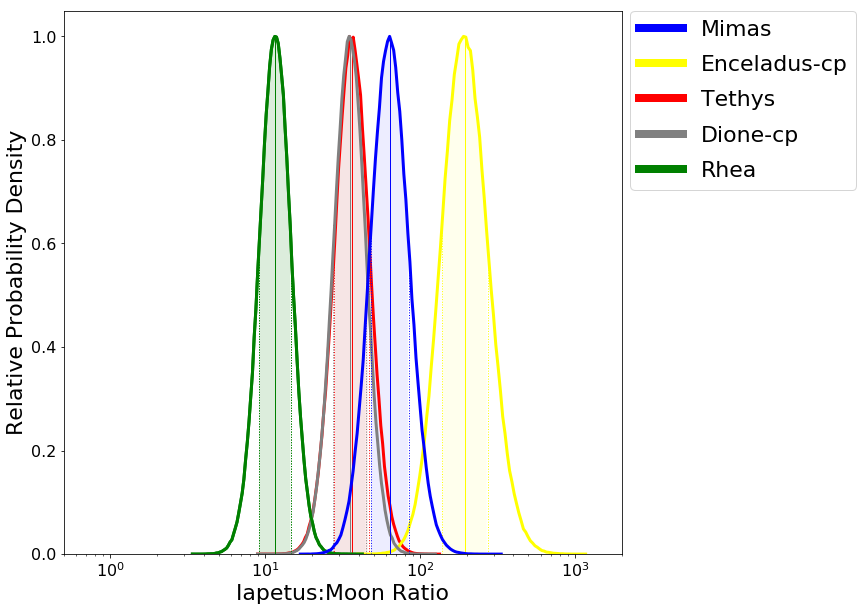

In [80]:
ax = plot_iapetus_fraction(ir_h48_dict,'Rhea')
for key in set(cp_keys)-{'Iapetus-bright'}:
    print(key.partition('-')[0])
    plot_iapetus_fraction(ir_h48_dict,key,ax=ax)
plt.xlabel('Iapetus:Moon Ratio',size=22)
custom_lines = [Line2D([0], [0], color=color_dict[key], lw=8) for key in cp_keys[:5]]
ax.legend(custom_lines, cp_keys[:5],labelspacing=0.7, fontsize=22, loc=5, bbox_to_anchor=(1.44, 0.835))

In [115]:
get_age_from_fraction(1-1/9.1265878712486739)

1793696937.1198516

In [116]:
get_age_from_fraction(1-1/47.822375565159362)

268987692.2119212

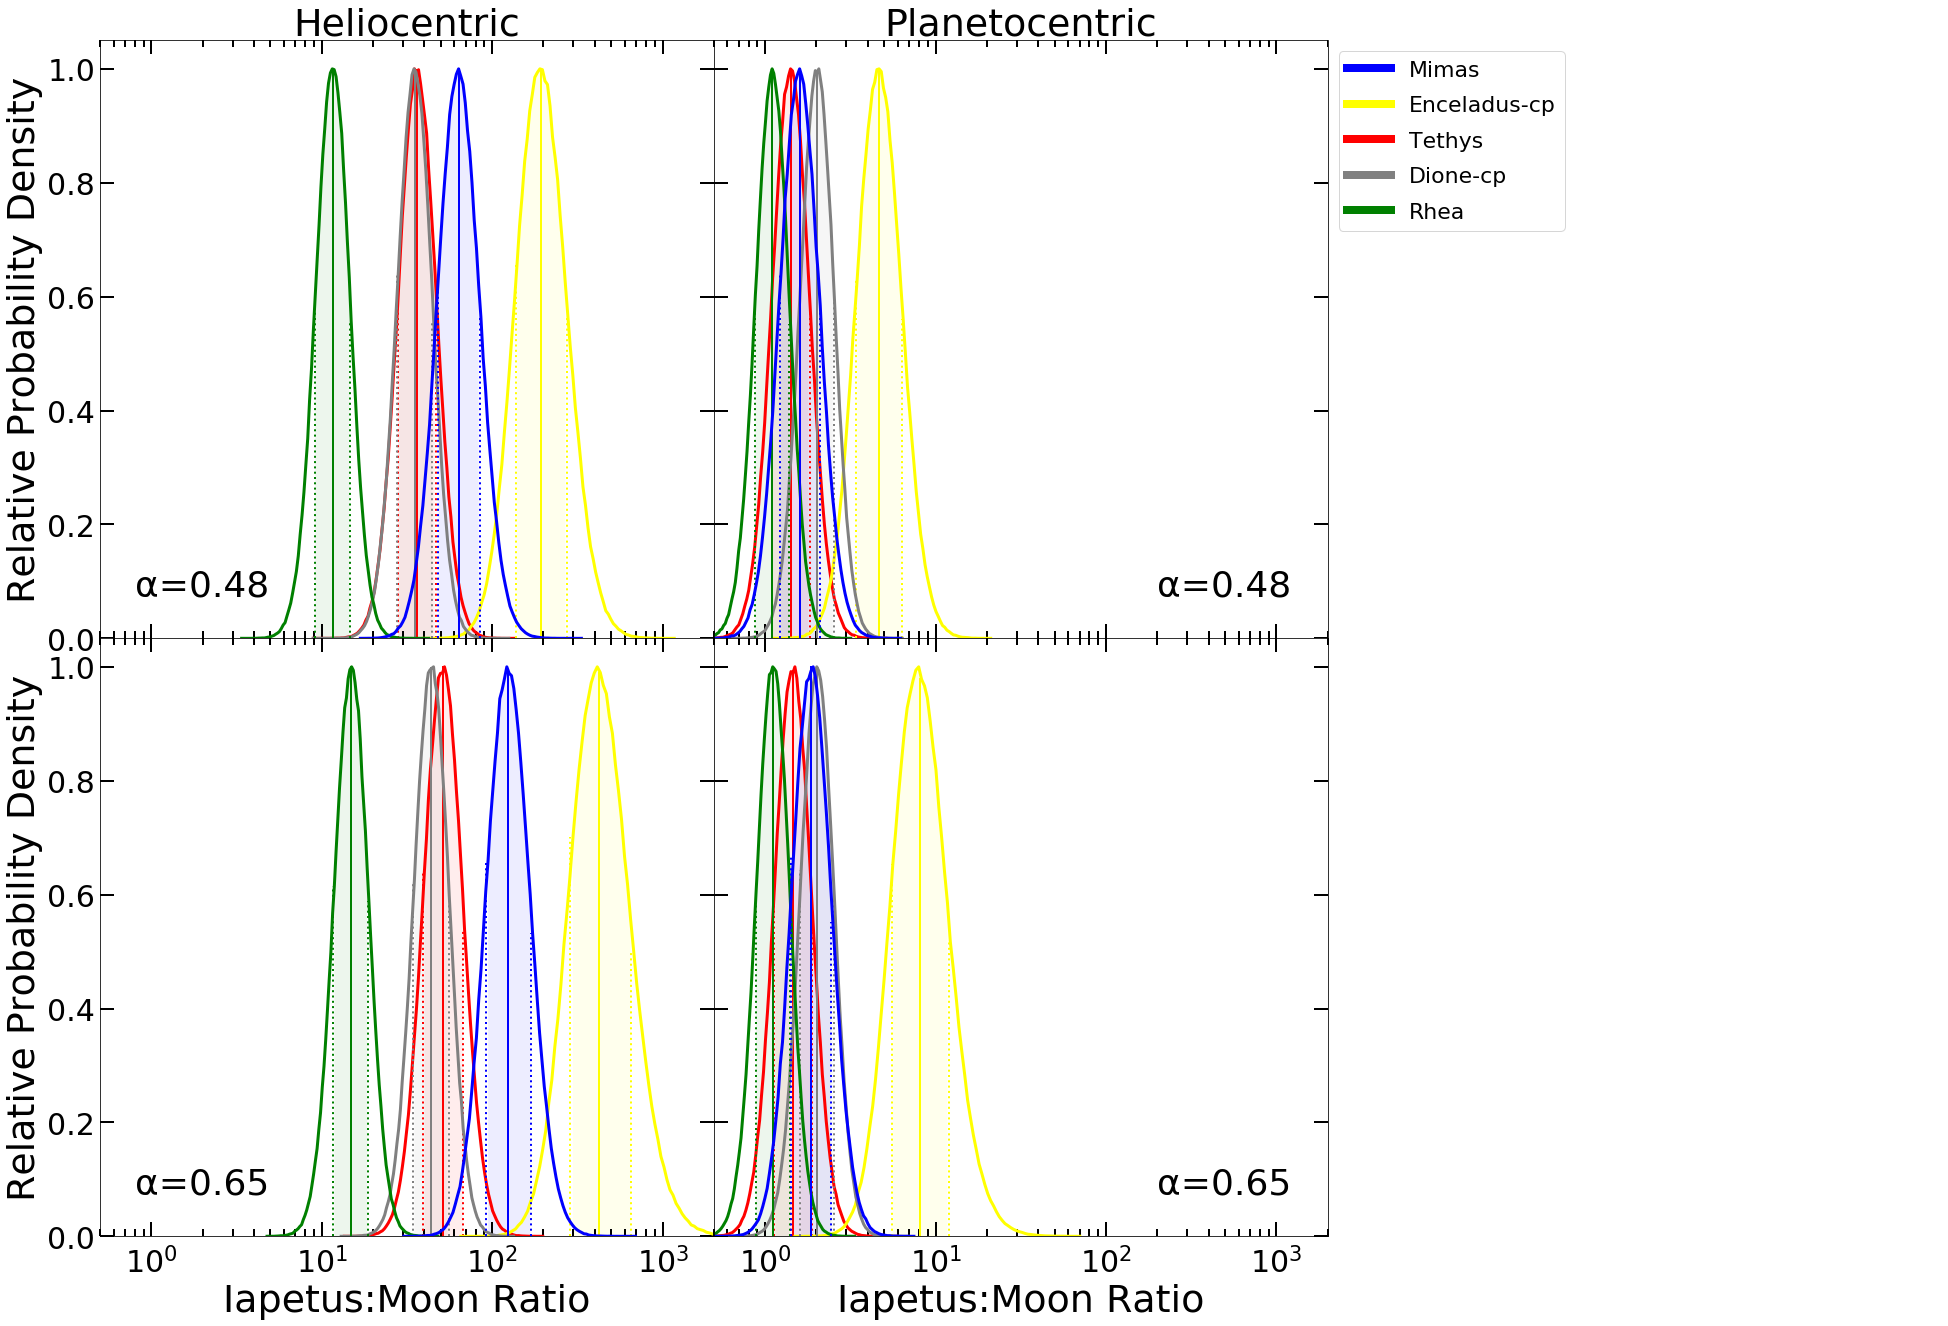

In [465]:
plt.rcParams['errorbar.capsize'] = 12
title_list = ['Heliocentric','Planetocentric','','','','']
ir_dict_list = [ir_h48_dict,ir_p48_dict,'',ir_h65_dict,ir_p65_dict,'']
fig = plt.figure(figsize=(33,22))
for i in list(range(6)):
    if i%3!=2:
        ax = fig.add_subplot(231 + i)
        ir_dict = ir_dict_list[i]
        plt.rcParams['errorbar.capsize'] = 12
        #plt.rcParams['lines.linewidth'] = 4
        #ax = plot_iapetus_fraction(ir_dict,'Rhea')
        for key in set(cp_keys)-{'Iapetus-bright'}:
            plot_iapetus_fraction(ir_dict,key,ax=ax,do_print=False)
        plt.xlabel('Iapetus:Moon Ratio',size=22)
        plt.xticks(size=30)
        if i%3==0:
            plt.yticks(size=30)
            plt.ylabel('Relative Probability Density',size=38)
        else:
            ax.get_yaxis().set_ticklabels([])
            plt.ylabel('',size=1)
        plt.xlabel('Iapetus:Moon Ratio',size=38)
        plt.title(title_list[i],size=38)
        if i%3==0:
            x_pos=0.8
        else:
            x_pos=200
        if i < 3:
            plt.text(x_pos,0.075,'α=0.48',fontsize=36)
        else:
            plt.text(x_pos,0.075,'α=0.65',fontsize=36)
    elif i==2:
        ax = fig.add_subplot(231 + i)
        custom_lines = [Line2D([0], [0], color=color_dict[key], lw=8) for key in cp_keys[:-1]]
        ax.legend(custom_lines, cp_keys[:-1],labelspacing=0.7, fontsize=22, loc=2)
        ax.get_yaxis().set_visible(False)
        ax.get_yaxis().set_ticklabels([])
        ax.get_xaxis().set_visible(False)
        ax.get_xaxis().set_ticklabels([])
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(length=14, width=2)
    ax.get_xaxis().set_tick_params(length=7, width=2, which='minor')
    ax.get_yaxis().set_tick_params(length=14, width=2)
    ax.get_yaxis().set_tick_params(length=7, width=2, which='minor')
    ax.get_xaxis().set_ticks_position('both')
    ax.get_yaxis().set_ticks_position('both')
    ax.get_xaxis().set_tick_params(pad=10, which='both')
    ax.get_yaxis().set_tick_params(pad=5, which='both')
    
fig.subplots_adjust(wspace=0,hspace=0)

fig=plt.gcf()
fig.savefig('IapetusRatioPanel.pdf', bbox_inches='tight')

In [83]:
def plot_age_fraction(binned_dict,key,n,ax='None'):
    moon_lines = get_lines(binned_dict,key,n)
    moon_percentiles=[10**get_percentile(moon_lines,log(titan_data.loc[0]['D']),i) for i in np.arange(0.05,100.0,0.05)]
    menrva_ndist = titan_data.loc[0]['ndist']
    age_dist_moon = (np.atleast_2d(np.array(menrva_ndist))*np.atleast_2d(1/np.array(moon_percentiles)).transpose()).flatten()
    print(tuple(np.percentile(age_dist_moon,[100-84.1345,50,84.1345])))
    if ax=='None':
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
    Y,bin_edges=np.histogram(np.log10(age_dist_moon),1000, density=True)
    bin_edges = 10**np.array(bin_edges)
    Y = np.array(Y)/max(Y)
    X =[np.mean([bin_edges[i], bin_edges[i+1]]) for i in list(range(len(bin_edges)-1))]
    plt.plot(X,Y,color_dict[key], linewidth=3)
    low1,med1,high1 = tuple(np.percentile(age_dist_moon,[100-84.1345,50,84.1345]))
    ax.fill_between(X,0,Y, where=((low1<X)&(X<high1)), facecolor=color_dict[key], alpha=0.07)
    ax.semilogx([med1,med1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > med1)]],color=color_dict[key])
    ax.semilogx([low1,low1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > low1)]],':',color=color_dict[key])
    ax.semilogx([high1,high1],[0,Y[next(x[0] for x in enumerate(X) if x[1] > high1)]],':',color=color_dict[key])
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel('Titan:' + key + ' Ratio at Menrva',size=22)
    plt.ylabel('Relative Probability Density',size=22)
    #plt.xlim([np.percentile(age_dist_moon,1),np.percentile(age_dist_moon,99)])
    plt.xlim([0.002,500])
    plt.ylim([0,1.05])
    return low1,med1,high1
    

(0.84487394279802541, 3.2197856018608739, 14.00946632789767)
(0.043832104323141552, 0.13559442920676162, 0.42088653522863861)
(2.7802275095794005, 10.296023815047457, 42.245612060501415)
(0.045350730692278615, 0.1411470243515533, 0.43869759873572234)
(0.55294326622575674, 1.3842799964856267, 2.9774711888431891)
(0.023384247557682921, 0.057430142231040107, 0.12014851666068732)
(1.1621560826547661, 2.9037795414657648, 6.2438639811757666)
(0.023347869028027761, 0.057536433787699251, 0.12076532392305522)
Run time: 121.69


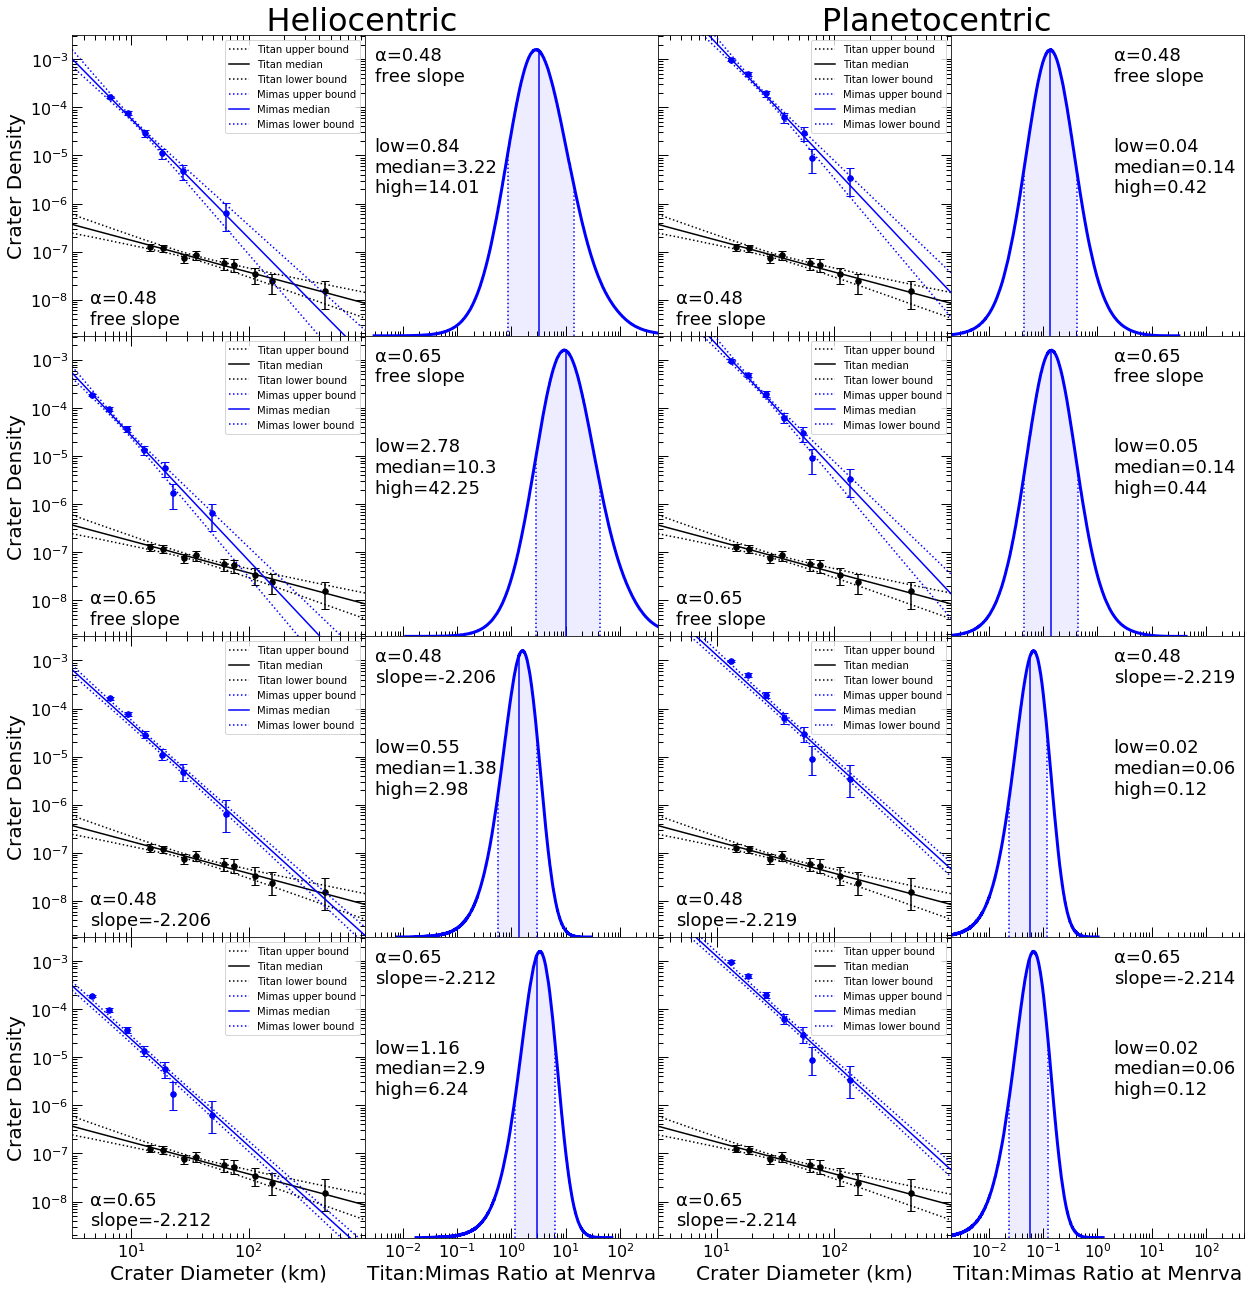

In [276]:
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['errorbar.capsize'] = 4
t1 = time.time()
n=10000
fig = plt.figure(figsize=(21,20))
for i in list(range(16)):
    if i%8<4:
        alpha = '0.48'
        if i%4<2:
            binned_dict = binned_dict_h48
            bs_dict = bs_h48_dict
            mean_m = mean_h48_m
        else:
            binned_dict = binned_dict_p48
            bs_dict = bs_p48_dict
            mean_m = mean_p48_m
    else:
        alpha = '0.65'
        if i%4<2:
            binned_dict = binned_dict_h65
            bs_dict = bs_h65_dict
            mean_m = mean_h65_m
        else:
            binned_dict = binned_dict_p65
            bs_dict = bs_p65_dict
            mean_m = mean_p65_m
    ax = fig.add_subplot(4,4,1 + i)
    if i%2==0:
        if i < 8:
            mstr = '\nfree slope'
            plot_moon_lines(binned_dict,'Mimas',n,ax=ax,do_legend=True)
        else:
            mstr = '\nslope='+str(round(mean_m,3))
            plot_mean_m_lines(bs_dict,binned_dict,'Mimas',ax=ax,do_legend=True)
        plt.xlabel('Crater Diameter (km)',size=20)
        plt.ylabel('Crater Density',size=20)
        plt.text(4.5,10**-8.5,'α='+alpha+mstr,fontsize=18)
    if i%4>1:
        ax.get_yaxis().set_ticklabels([])
        plt.ylabel('',size=1)
    if i%2==1:
        if i < 8:
            low1,med1,high1 = plot_age_fraction(binned_dict,'Mimas',n,ax=ax)
        else:
            low1,med1,high1 = plot_age_fraction_mean_m(bs_dict,'Mimas',ax=ax)
        ax.get_yaxis().set_ticklabels([])
        plt.xlabel('Titan:' + 'Mimas' + ' Ratio at Menrva',size=20)
        if i%4<=2:
            xpos = 0.003
        else:
            xpos = 2
        plt.text(xpos,0.89,'α='+alpha+mstr,fontsize=18)
        plt.text(xpos,0.5,'low='+str(round(low1,2))\
                 +'\nmedian='+str(round(med1,2))\
                 +'\nhigh='+str(round(high1,2)),fontsize=18)
        ax.get_yaxis().set_visible(False)
    else:
        ax.get_xaxis().set_ticks_position('both')
        ax.get_yaxis().set_ticks_position('both')
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(length=10, width=1)
    ax.get_xaxis().set_tick_params(length=5, width=1, which='minor')
    ax.get_yaxis().set_tick_params(length=10, width=1)
    ax.get_yaxis().set_tick_params(length=5, width=1, which='minor')
plt.xticks(size=15)
plt.yticks(size=15)
fig.suptitle('    Heliocentric' + 36*' ' + 'Planetocentric',size=32)
fig.subplots_adjust(wspace=0, hspace=0,top=0.96)
t2=time.time()
print('Run time: ' + str(round(t2-t1,2)))
fig=plt.gcf()
fig.savefig('TitanMimasAgeFractionPanel.pdf', bbox_inches='tight')

(0.011986711928389286, 0.030522622742682165, 0.068234079738115572)
(0.013333431086829186, 0.033225924948242974, 0.071246341707277408)
(0.010596640752623922, 0.026935660892943223, 0.060044571589150053)
(0.011438988261633847, 0.028419041336548399, 0.060685103552849895)
(0.016190110876670549, 0.039178063647477085, 0.079877777649840803)
(0.014816468333142202, 0.035864734840308735, 0.073126110868906496)
(0.014092415490659101, 0.034083775984952824, 0.069345532170647289)
(0.012871962654826763, 0.031207365401304536, 0.063833060968352714)
Run time: 122.63


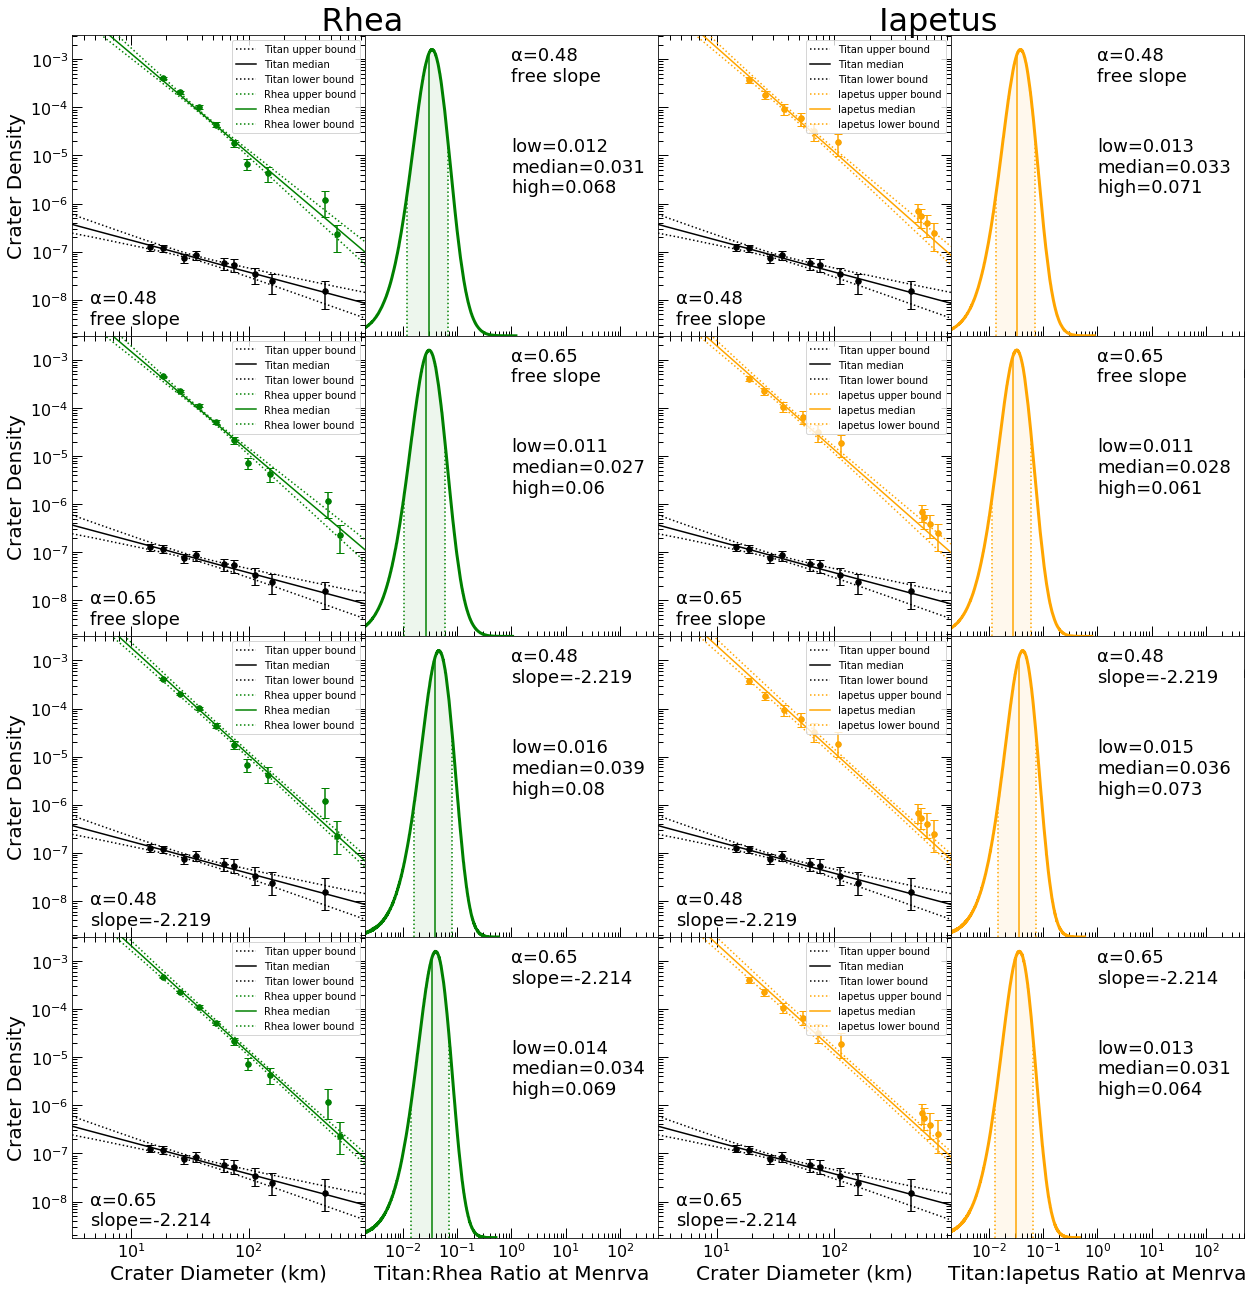

In [281]:
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['errorbar.capsize'] = 4
t1 = time.time()
n=10000
fig = plt.figure(figsize=(21,20))
for i in list(range(16)):
    if i%4<2:
        key='Rhea'
    else:
        key='Iapetus-bright'
    if i%8<4:
        alpha = '0.48'
        binned_dict = binned_dict_p48
        bs_dict = bs_p48_dict
        mean_m = mean_p48_m
    else:
        alpha = '0.65'
        binned_dict = binned_dict_p65
        bs_dict = bs_p65_dict
        mean_m = mean_p65_m
    ax = fig.add_subplot(4,4,1 + i)
    if i%2==0:
        if i < 8:
            mstr = '\nfree slope'
            plot_moon_lines(binned_dict,key,n,ax=ax,do_legend=True)
        else:
            mstr = '\nslope='+str(round(mean_m,3))
            plot_mean_m_lines(bs_dict,binned_dict,key,ax=ax,do_legend=True)
        plt.xlabel('Crater Diameter (km)',size=20)
        plt.ylabel('Crater Density',size=20)
        plt.text(4.5,10**-8.5,'α='+alpha+mstr,fontsize=18)
    if i%4>1:
        ax.get_yaxis().set_ticklabels([])
        plt.ylabel('',size=1)
    if i%2==1:
        if i < 8:
            low1,med1,high1 = plot_age_fraction(binned_dict,key,n,ax=ax)
        else:
            low1,med1,high1 = plot_age_fraction_mean_m(bs_dict,key,ax=ax)
        ax.get_yaxis().set_ticklabels([])
        plt.xlabel('Titan:' + key.partition('-')[0] + ' Ratio at Menrva',size=20)
        if i%4<=2:
            xpos = 1
        else:
            xpos = 1
        plt.text(xpos,0.89,'α='+alpha+mstr,fontsize=18)
        plt.text(xpos,0.5,'low='+str(round(low1,3))\
                 +'\nmedian='+str(round(med1,3))\
                 +'\nhigh='+str(round(high1,3)),fontsize=18)
        ax.get_yaxis().set_visible(False)
    else:
        ax.get_xaxis().set_ticks_position('both')
        ax.get_yaxis().set_ticks_position('both')
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(length=10, width=1)
    ax.get_xaxis().set_tick_params(length=5, width=1, which='minor')
    ax.get_yaxis().set_tick_params(length=10, width=1)
    ax.get_yaxis().set_tick_params(length=5, width=1, which='minor')
plt.xticks(size=15)
plt.yticks(size=15)
fig.suptitle('    Rhea' + 47*' ' + 'Iapetus',size=32)
fig.subplots_adjust(wspace=0, hspace=0,top=0.96)
t2=time.time()
print('Run time: ' + str(round(t2-t1,2)))
fig=plt.gcf()
fig.savefig('TitanRheaIapetusAgeFractionPanel.pdf', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

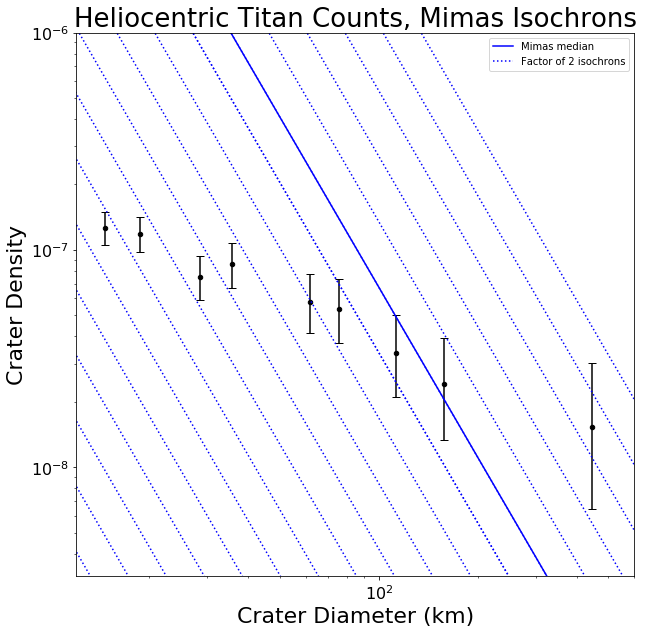

In [293]:
fig=plt.figure(figsize=(10,10))
key='Mimas'
moon_lines = get_lines(binned_dict_h65,key,n)
xe = np.arange(0.5,3,0.01)
mmimas = [10**get_percentile(moon_lines,xei,50.0) for xei in xe]
ax = binned_dict_h65[key].plot(y='density_sf',x='D_sf',logx=True, logy=True, kind='scatter', color='white')
titan_data.plot(y='density', x='D', yerr=np.array([titan_data[['lower','upper']].values.transpose()]), color='black', \
                logx=True, logy=True, kind='scatter', ax=ax, figsize=(10,10))
pd.DataFrame({'1/' + str(2**i) + ' Mimas':np.array(mmimas)/2**i for i in list(range(-5,15))},index=[10**i for i in xe]).plot(\
                logx=True, logy=True, ax=ax, figsize=(10,10), color=color_dict[key],\
                style=':', legend=False)
pd.DataFrame({'Mimas median':mmimas},index=[10**i for i in xe]).plot(\
                logx=True, logy=True, ax=ax, figsize=(10,10), color=color_dict[key],\
                style='-', legend=True)
pd.DataFrame({'Factor of 2 isochrons':np.array(mmimas)/2},index=[10**i for i in xe]).plot(\
                logx=True, logy=True, ax=ax, figsize=(10,10), color=color_dict[key],\
                style=':', legend=True)
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylim([10**-8.5,10**-6])
plt.xlim([12,600])
plt.xlabel('Crater Diameter (km)',size=22)
plt.ylabel('Crater Density',size=22)
plt.title('Heliocentric Titan Counts, Mimas Isochrons',size=26)
fig.savefig('HeliocentricMimasIsochrons.pdf')

In [123]:
def get_h1crater_dict(alpha):
    big_D_dict = {'Mimas':139.0, 'Tethys':445.0, 'Dione-cp':350,'Rhea':480,'Iapetus-bright':580.0,'Titan':titan_ds['D'][0]}
    i_e=3.5
    return_dict = dict()
    for key in big_D_dict.keys():
        full_area = r_dict[key]**2 * math.pi * 4 /1000000.0
        sf = d_scale_factor_h(0.05, e_dict[key], m_dict[key], r_dict[key], ro_dict[key], alpha)
        pt = pt_dict[key]
        gmeans_d = big_D_dict[key] * sf
        binned_d = ig_50(1.0)/full_area/pt
        binned_l = ig_lower(1.0)/full_area/pt
        binned_u = ig_upper(1.0)/full_area/pt
        binned_ndist = ig_ndist(1.0,i_e)/full_area/pt
        return_dict[key] = {'D_sf':gmeans_d, 'density_sf':binned_d, 'lower_sf':binned_l, 'upper_sf':binned_u, 'ndist_sf':binned_ndist}
    return return_dict

In [313]:
h1crater_dict65 = get_h1crater_dict(0.65)
h1crater_dict48 = get_h1crater_dict(0.48)

Text(0, 0.5, 'Crater Density')

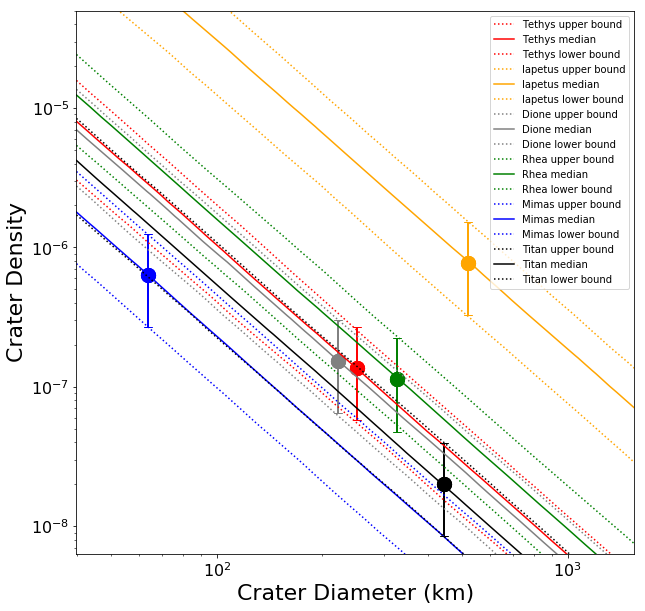

In [318]:
fig = plt.figure(figsize=(10,10))
for i in list(range(1)):
    if i%3!=2:
        ax = fig.add_subplot(111 + i)
mean_m = mean_h48_m
ax = pd.DataFrame(h1crater_dict48['Tethys']).plot(y='density_sf',x='D_sf',logx=True, 
                                            logy=True, kind='scatter', legend=True, ax=ax)

for key in {'Mimas', 'Tethys', 'Dione-cp','Rhea','Iapetus-bright','Titan'}:
    pd.DataFrame(h1crater_dict48[key]).iloc[:3].plot(y='density_sf',x='D_sf', 
            yerr=np.array([pd.DataFrame(h1crater_dict48[key]).iloc[:3][['lower_sf','upper_sf']].values.transpose()]), 
            logx=True, logy=True, kind='scatter', 
            ax=ax, color=color_dict[key], legend=True, s=200)
        
    bs = []
    x = h1crater_dict48[key]['D_sf']
    n = 1000
    for i in list(range(n)):
        y = log(random.choice(h1crater_dict48[key]['ndist_sf']))
        m = np.random.choice(mean_h48_m_dist)
        b = y - m * log(x)
        bs.append((m,b))

    xe = np.arange(1.6,3.2,0.01)
    mmoon = [np.median([10**(m*xei + b) for m,b in bs]) for xei in xe]
    umoon = [np.percentile([10**(m*xei + b) for m,b in bs], 84.1345) for xei in xe]
    lmoon = [np.percentile([10**(m*xei + b) for m,b in bs], 100.0-84.1345) for xei in xe]
    pd.DataFrame({key.partition('-')[0] + ' upper bound':umoon, key.partition('-')[0] + ' median':mmoon, \
                  key.partition('-')[0] + ' lower bound':lmoon},index=[10**i for i in xe]).plot(\
                        logx=True, logy=True, ax=ax, color=color_dict[key],\
                        style=[':','-',':'], legend=True)
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylim([10**-8.2,10**-4.3])
plt.xlabel('Crater Diameter (km)',size=22)
plt.ylabel('Crater Density',size=22)

In [371]:
def get_iapetus_ratio_h1crater_dict(h1crater_dict,mean_m_dist,n):
    mt1=time.time()
    print('Generating inputs...')
    t1=time.time()
    input_list = [mean_m_dist for i in range(n)]
    with Pool(5) as pool:
        m_list = pool.map(np.random.choice,input_list)
        pool.close()
    t2=time.time()
    print('Inputs generated in: ' + str(round(t2-t1,3)) + ' s\nCalculating ratios...')
    bs_dict = {}
    for key in {'Mimas', 'Tethys', 'Dione-cp','Rhea','Iapetus-bright','Titan'}:
        t1=time.time()
        bs = []
        for m in m_list:
            x = h1crater_dict[key]['D_sf']
            y = log(random.choice(h1crater_dict[key]['ndist_sf']))
            b = y - m * log(x)
            bs.append(b)
        bs_dict[key] = np.array(bs)
        t2=time.time()
        print(key.partition('-')[0] + ' b values calculated in: ' + str(round(t2-t1,3)) + ' s')
    ratio_dict = {}
    print('Dividing...')
    t1=time.time()
    for key in {'Mimas', 'Tethys', 'Dione-cp','Rhea','Titan'}:
        ratio_dict[key] = 10**(bs_dict['Iapetus-bright']-bs_dict[key])
    t2=time.time()
    print('Divisions finished in: ' + str(round(t2-t1,3)) + ' s')
    mt2=time.time()
    print('Full run time: ' + str(round(mt2-mt1,3)) + ' s')
    return ratio_dict

In [388]:
if False:
    h1crater_ir_dict48 = get_iapetus_ratio_h1crater_dict(h1crater_dict48,mean_h48_m_dist,10000000)
    h1crater_ir_dict65 = get_iapetus_ratio_h1crater_dict(h1crater_dict65,mean_h65_m_dist,10000000)
    pkl.dump( h1crater_ir_dict48, open('h1crater_ir_dict48.pkl', 'wb'))
    pkl.dump( h1crater_ir_dict65, open('h1crater_ir_dict65.pkl', 'wb'))
else:
    h1crater_ir_dict48 = pkl.load(open('h1crater_ir_dict48.pkl', 'rb'))
    h1crater_ir_dict65 = pkl.load(open('h1crater_ir_dict65.pkl', 'rb'))

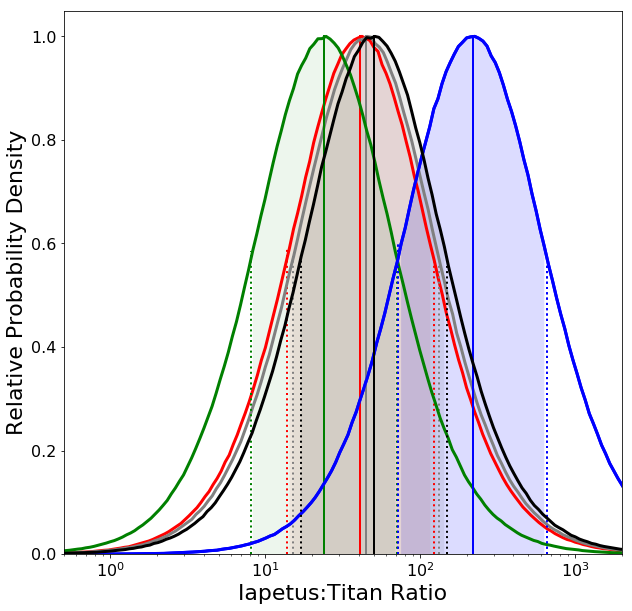

In [464]:
ax = plot_iapetus_fraction(h1crater_ir_dict65,'Mimas',n_bins=200,do_print=False)
for key in {'Mimas', 'Tethys', 'Dione-cp','Rhea','Titan'}:
    plot_iapetus_fraction(h1crater_ir_dict65,key,n_bins=200,do_print=False,ax=ax)

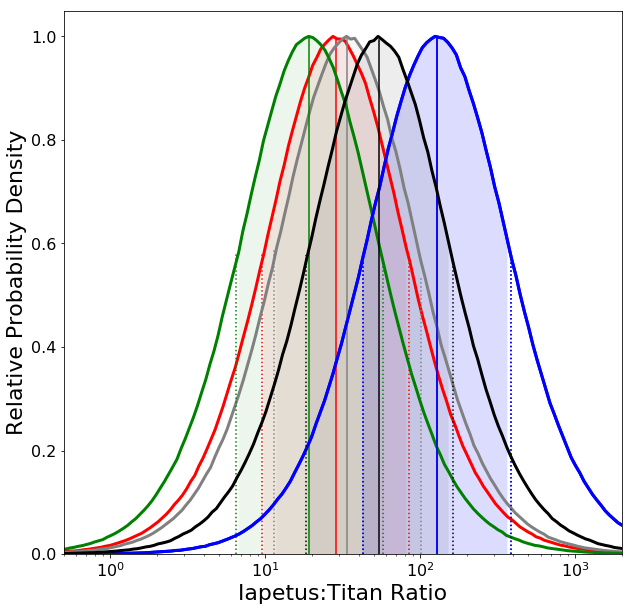

In [399]:
ax = plot_iapetus_fraction(h1crater_ir_dict48,'Mimas',n_bins=200,do_print=False)
for key in {'Mimas', 'Tethys', 'Dione-cp','Rhea','Titan'}:
    plot_iapetus_fraction(h1crater_ir_dict48,key,n_bins=200,do_print=False,ax=ax)

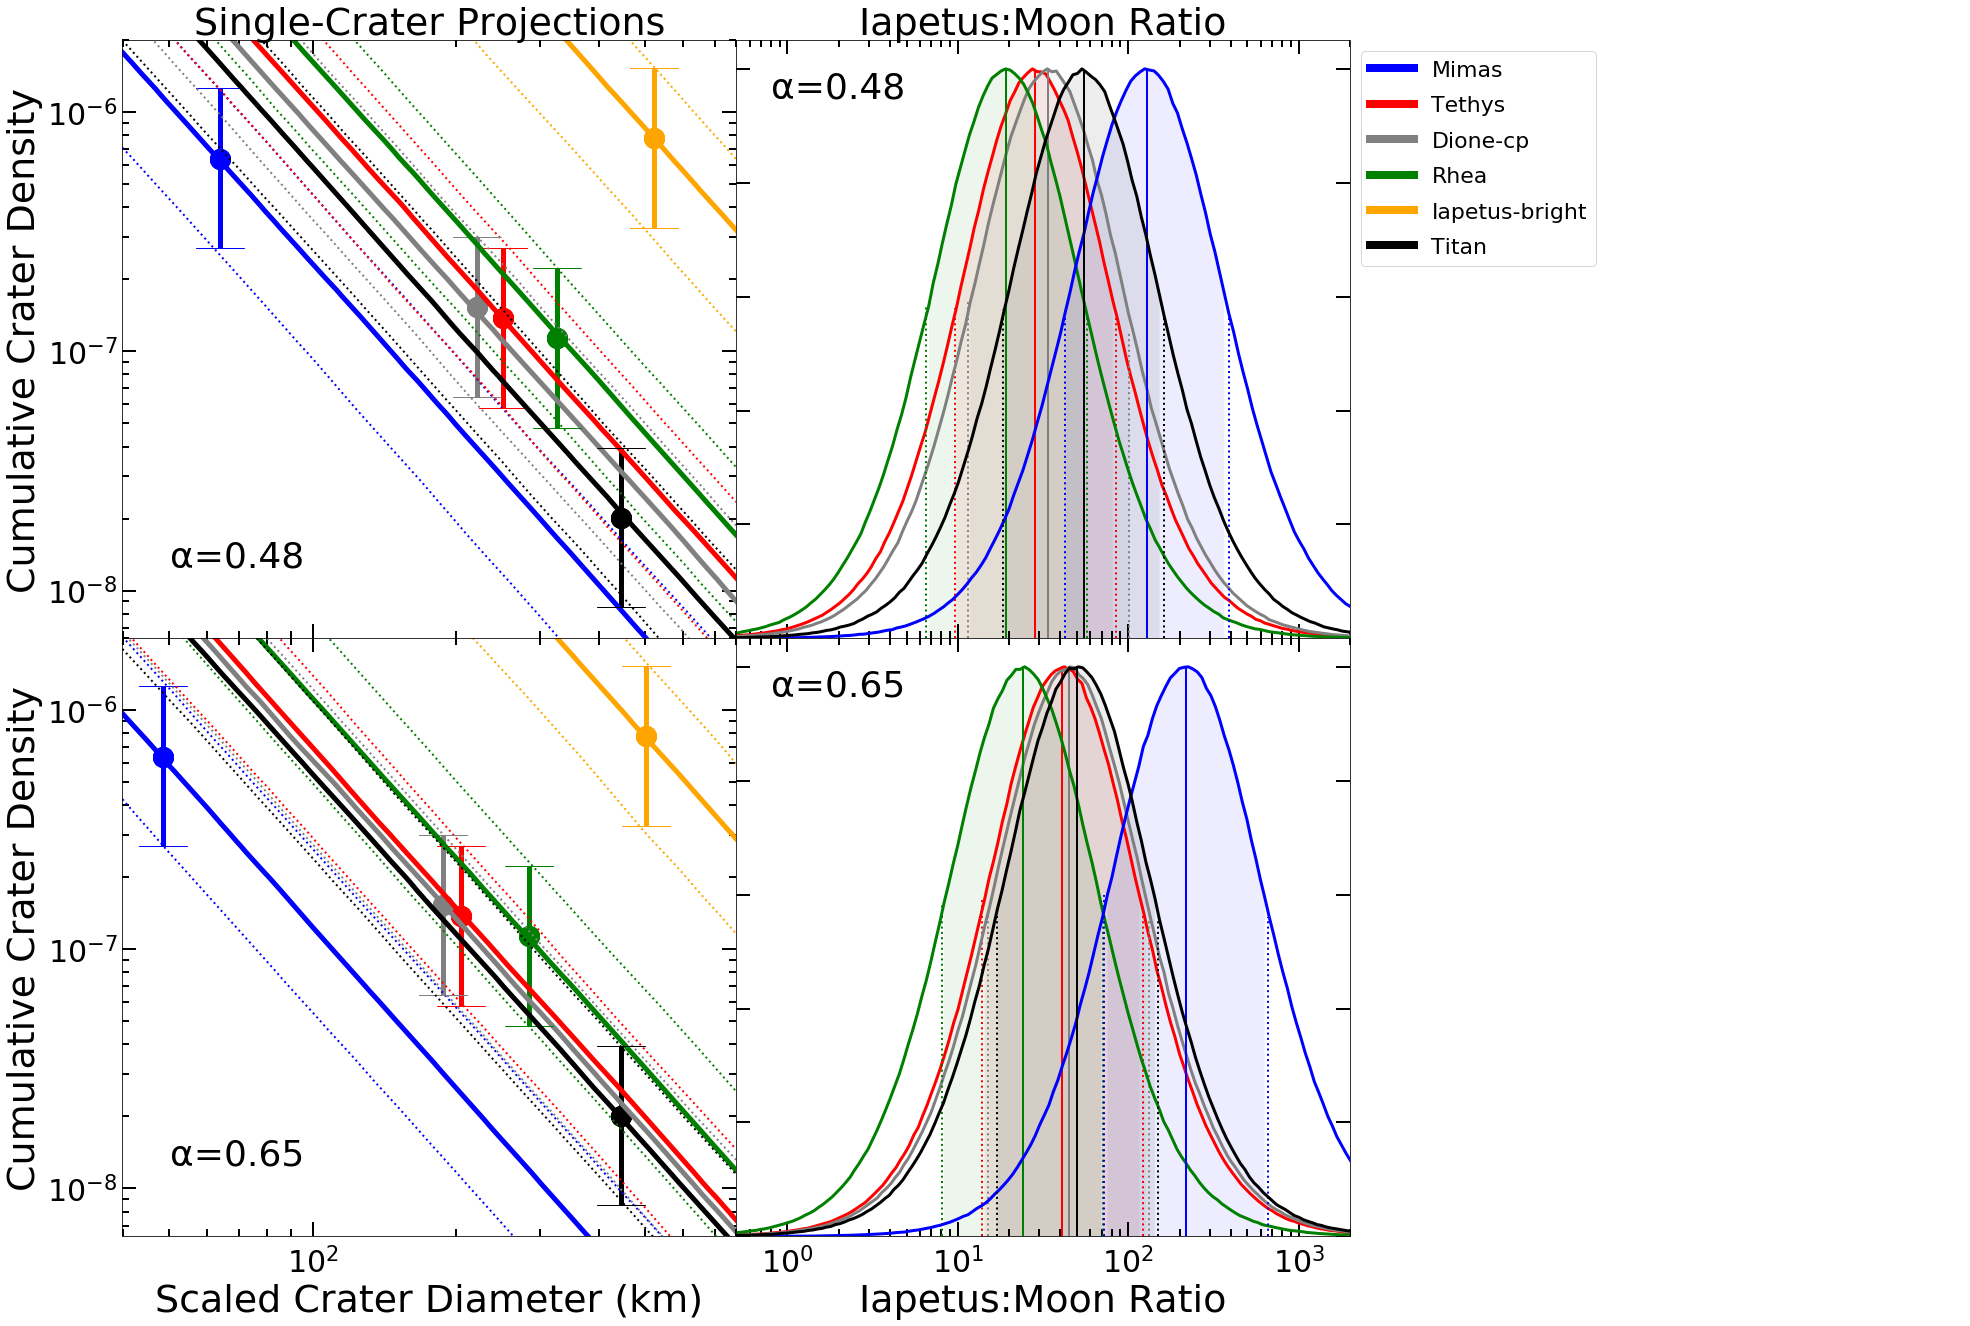

In [490]:
plt.rcParams['errorbar.capsize'] = 12
title_list = ['Single-Crater Projections','Iapetus:Moon Ratio','','','','']
ir_dict_list = ['',h1crater_ir_dict48,'','',h1crater_ir_dict65,'']
fig = plt.figure(figsize=(33,22))
key_list = ['Mimas', 'Tethys', 'Dione-cp','Rhea','Iapetus-bright','Titan']
for i in list(range(5)):
    if i%3==1:
        ax = fig.add_subplot(231 + i)
        ir_dict = ir_dict_list[i]
        plt.rcParams['errorbar.capsize'] = 12
        plt.rcParams['lines.linewidth'] = 2
        for key in {'Mimas', 'Tethys', 'Dione-cp','Rhea','Titan'}:
            plot_iapetus_fraction(ir_dict,key,ax=ax,do_print=False,n_bins=200)
        plt.xticks(size=30)
        ax.get_yaxis().set_ticklabels([])
        plt.ylabel('',size=1)
        plt.xlabel('Iapetus:Moon Ratio',size=38)
        plt.title(title_list[i],size=38)
        if i < 3:
            plt.text(0.8,0.95,'α=0.48',fontsize=36)
        else:
            plt.text(0.8,0.95,'α=0.65',fontsize=36)
    elif i%3==0:
        ax = fig.add_subplot(231 + i)
        if i==0:
            alpha_str = '48'
            mean_m_dist = mean_h48_m_dist
            h1crater_dict = h1crater_dict48
        elif i==3:
            alpha_str = '65'
            mean_m_dist = mean_h65_m_dist
            h1crater_dict = h1crater_dict65
        for key in key_list:
            bs = []
            x = h1crater_dict[key]['D_sf']
            n = 1000
            for j in list(range(n)):
                y = log(random.choice(h1crater_dict[key]['ndist_sf']))
                m = np.random.choice(mean_m_dist)
                b = y - m * log(x)
                bs.append((m,b))

            xe = np.arange(1.6,2.9,0.01)
            mmoon = [np.median([10**(m*xei + b) for m,b in bs]) for xei in xe]
            umoon = [np.percentile([10**(m*xei + b) for m,b in bs], 84.1345) for xei in xe]
            lmoon = [np.percentile([10**(m*xei + b) for m,b in bs], 100.0-84.1345) for xei in xe]
            pd.DataFrame({key.partition('-')[0] + ' upper bound':umoon, key.partition('-')[0] + ' median':mmoon, \
                          key.partition('-')[0] + ' lower bound':lmoon},index=[10**i for i in xe]).plot(\
                                logx=True, logy=True, ax=ax, color=color_dict[key],\
                                style=[':','-',':'], legend=False,lw=2)
            pd.DataFrame({key.partition('-')[0] + ' median':mmoon},index=[10**i for i in xe]).plot(\
                                logx=True, logy=True, ax=ax, color=color_dict[key],\
                                style=['-'], legend=False,lw=5)
            plt.rcParams['lines.linewidth'] = 5
            plt.rcParams['errorbar.capsize'] = 24
            pd.DataFrame(h1crater_dict[key]).iloc[:3].plot(y='density_sf',x='D_sf',
                    yerr=np.array([pd.DataFrame(h1crater_dict[key]).iloc[:3][['lower_sf','upper_sf']].values.transpose()]), 
                    logx=True, logy=True, kind='scatter', 
                    ax=ax, color=color_dict[key], legend=False, s=400)
            plt.rcParams['lines.linewidth'] = 2
            plt.rcParams['errorbar.capsize'] = 12
        plt.text(10**1.7,10**-7.9,'α=0.' + alpha_str,fontsize=36)
        plt.xticks(size=30)
        plt.yticks(size=30)
        plt.ylim([10**-8.2,10**-5.7])
        plt.xlabel('Scaled Crater Diameter (km)',size=38)
        plt.ylabel('Cumulative Crater Density',size=38)
        plt.title(title_list[i],size=38)

    elif i==2:
        ax = fig.add_subplot(231 + i)
        custom_lines = [Line2D([0], [0], color=color_dict[key], lw=8) for key in key_list]
        ax.legend(custom_lines, key_list,labelspacing=0.7, fontsize=22, loc=2)
        ax.get_yaxis().set_visible(False)
        ax.get_yaxis().set_ticklabels([])
        ax.get_xaxis().set_visible(False)
        ax.get_xaxis().set_ticklabels([])
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
    ax.get_xaxis().set_tick_params(direction='in', which='both')
    ax.get_yaxis().set_tick_params(direction='in', which='both')
    ax.get_xaxis().set_tick_params(length=14, width=2)
    ax.get_xaxis().set_tick_params(length=7, width=2, which='minor')
    ax.get_yaxis().set_tick_params(length=14, width=2)
    ax.get_yaxis().set_tick_params(length=7, width=2, which='minor')
    ax.get_xaxis().set_ticks_position('both')
    ax.get_yaxis().set_ticks_position('both')
    ax.get_xaxis().set_tick_params(pad=10, which='both')
    ax.get_yaxis().set_tick_params(pad=5, which='both')
    
fig.subplots_adjust(wspace=0,hspace=0)

fig=plt.gcf()
fig.savefig('OneCraterSaturationPanel.pdf', bbox_inches='tight')